In [ ]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.4 MB/s eta 0:00:00


# Загрузка библиотек

In [ ]:
import sys 
import os
from glob import glob
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle
import random
from tqdm import tqdm
import math 
import time
from lxml import etree

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
import seaborn as sns


from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU # Стандартные слои Keras
from tensorflow.keras.regularizers import l2 # Регуляризатор l2
from tensorflow.keras.optimizers import Adam, SGD # Оптимизатор Adam
from tensorflow.keras.models import Model # Абстрактный класс Model
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb # Модули конвертации между RGB и HSV
from google.colab import files # Модуль работы с файловой системой google
import tensorflow.keras.backend as K # бэкенд Keras
import tensorflow as tf # TensorFlow
import cv2

# CONFiG

In [ ]:
class CFG:
    seed = 42
    img_size = (256,512,3)
    BATCH_SIZE = 32
    validation_size = 0.2
    BUFFER_SIZE = 100

Autotune = tf.data.AUTOTUNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Вспомогательные функции

In [ ]:
def load_image(image_file):
    '''load a image file'''
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image, channels = CFG.img_size[2])  # Decode a JPEG-encoded image to a uint8 tensor.
    image = tf.cast(image, tf.float32)                            # uint8 to float32
    image = image/255.0         
    return image


def resize(input_image):
    '''resize the image based on given height and width'''
    input_image = tf.image.resize(input_image, CFG.img_size[:2])
    return input_image

def load_resize_image(image_path):
    '''load and resize the image'''
    img = load_image(image_path)
    img = resize(img)
    img = tf.cast(img, tf.float32)
    return img

In [ ]:
def plot_sample(sample_id):
    
    '''plot a sample image'''
    
    xmin,xmax,ymin,ymax,label = df.loc[sample_id,['xmin','xmax','ymin','ymax','defect_class']]

    fig,ax = plt.subplots(figsize = (10,5))
    rect = Rectangle(xy = (xmin,ymin),
                     width = (xmax - xmin),
                     height = (ymax - ymin), 
                     fill = False, 
                     color = "r")  

    ax.axes.add_patch(rect)

    plt.imshow(plt.imread(df.loc[sample_id,'image_path']), cmap = 'gray')
    plt.title(f'Defect - {label}')
    plt.show()

# Loading data

In [ ]:
image_dir = 'drive/MyDrive/Project/data/images/images/'
label_dir = 'drive/MyDrive/Project/data/label/label/'

In [ ]:
label_paths = glob(f'{label_dir}*.xml')
len(label_paths)

2280

In [ ]:
image_paths = glob(f'{image_dir}/*/*.jpg')
len(image_paths)

2752

In [ ]:
#проверим, что разметка и изображения мэчатся между собой

img_names = [path.rsplit('/',1)[1].split('.')[0] for path in image_paths] 
sum([lab_path.rsplit('/',1)[1].split('.')[0] in img_names for lab_path in label_paths])

2280

In [ ]:
def read_xml(path):
    '''read the xml label file to get the bounding box'''
    
    d = {}
    
    d['file_id'] = path.rsplit('/',1)[1].split('.')[0]
    
    with open(path) as f:
        xml_f = etree.HTML(f.read())
        
    # ширина и высота
    d["width"] = int(xml_f.xpath("//size/width/text()")[0])
    d['height'] = int(xml_f.xpath("//size/height/text()")[0])  
    
    # координаты bounding box 
    d["xmin"] = xml_f.xpath("//bndbox/xmin/text()")[0]
    d['xmax'] = xml_f.xpath("//bndbox/xmax/text()")[0]
    d['ymin'] = xml_f.xpath("//bndbox/ymin/text()")[0]
    d['ymax'] = xml_f.xpath("//bndbox/ymax/text()")[0]

    d['defect_class_2'] = xml_f.xpath("//object/name/text()")
    
    return d

In [ ]:
img_metadata = []

for label in tqdm(label_paths):
    imageinfo = read_xml(label)
    
    file_id = imageinfo['file_id']
    imageinfo['image_path'] = glob(f'{image_dir}*/{file_id}.jpg')[0]
    
    imageinfo['defect_class'] = imageinfo['image_path'].rsplit('/',2)[1]
    img_metadata.append(imageinfo)
    
df = pd.DataFrame.from_records(img_metadata)    

100%|██████████| 2280/2280 [00:56<00:00, 40.03it/s] 


In [ ]:
df.shape

(2280, 10)

In [ ]:
#сохранение словаря "название класса": "номер класса" в config
CFG.class_dict = {val: idx for idx, val in enumerate(df.defect_class.unique())}
CFG.num_classes = len(CFG.class_dict)

#inverse mapping dictionary 
int_2_class = {idx: clss for clss, idx in CFG.class_dict.items()}

CFG.class_dict

{'water_spot': 0,
 'inclusion': 1,
 'waist_folding': 2,
 'punching_hole': 3,
 'silk_spot': 4,
 'welding_line': 5,
 'oil_spot': 6,
 'crease': 7,
 'crescent_gap': 8,
 'rolled_pit': 9}

In [ ]:
df['xmin'] = df['xmin'].apply(lambda x: int(x))
df['xmax'] = df['xmax'].apply(lambda x: int(x))
df['ymin'] = df['ymin'].apply(lambda x: int(x))
df['ymax'] = df['ymax'].apply(lambda x: int(x))

df['defect_id'] = df['defect_class'].map(CFG.class_dict)

In [ ]:
df.head()

file_id  width  height  xmin  xmax  ymin  ymax  \
0  img_03_4405000700_00831   2048    1000   876  1007   144   973   
1  img_04_4402622500_00355   2048    1000  1044  1090   334   373   
2  img_06_3436639700_00756   2048    1000  1453  1958   134   827   
3  img_08_4403744200_01180   2048    1000     1   308     1   664   
4   img_06_425640100_00874   2048    1000  1861  1969   619   678   

                      defect_class_2  \
0                        [4_shuiban]   
1                           [7_yiwu]   
2                       [10_yaozhed]   
3                        [4_shuiban]   
4  [1_chongkong, 2_hanfeng, 6_siban]   

                                          image_path   defect_class  defect_id  
0  drive/MyDrive/Project/data/images/images/water...     water_spot          0  
1  drive/MyDrive/Project/data/images/images/inclu...      inclusion          1  
2  drive/MyDrive/Project/data/images/images/waist...  waist_folding          2  
3  drive/MyDrive/Project/data/images/images/water...     water_spot          0  
4  drive/MyDrive/Project/data/images/images/punch...  punching_hole          3

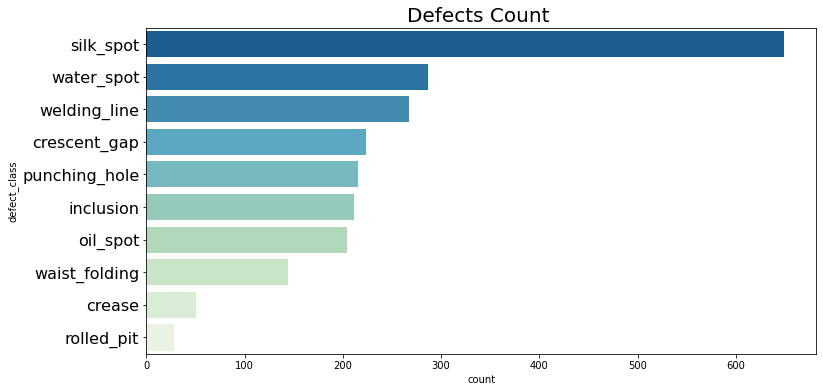

In [ ]:
plt.figure(figsize=(12,6))
plt.yticks(fontsize=16)
sns.countplot(y="defect_class",
              data=df,
              palette="GnBu_r",
              order=df['defect_class'].value_counts().index,
              linewidth=3)
plt.title("Defects Count ", size=20, color='k')
plt.show()

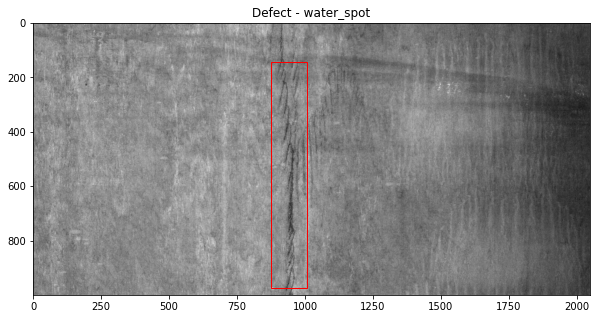

In [ ]:
plot_sample(0)

# 1. Baseline

## 1.1.Data Pipeline

In [ ]:
def get_dataset(df,
                labels_exist = True,
                shuffle = True):
    
    if labels_exist:
        im_ds = tf.data.Dataset.from_tensor_slices(df.image_path)  # create a dataset from a python list       
        im_ds = im_ds.map(load_resize_image)
        
        labels = tf.data.Dataset.from_tensor_slices(df['defect_id'].values)
        xmin = tf.data.Dataset.from_tensor_slices(df['xmin'].values)
        ymin = tf.data.Dataset.from_tensor_slices(df['ymin'].values)
        xmax = tf.data.Dataset.from_tensor_slices(df['xmax'].values)
        ymax = tf.data.Dataset.from_tensor_slices(df['ymax'].values)

        labels_ds = tf.data.Dataset.zip((labels,xmin,xmax,ymin,ymax))         
        dataset = tf.data.Dataset.zip((im_ds,labels_ds))
        
    else:
        dataset = tf.data.Dataset.list_files(df.image_path)
        dataset = dataset.map(load_resize_image, num_parallel_calls=Autotune)
     
    if shuffle:
        dataset = dataset.shuffle(CFG.BUFFER_SIZE, seed=CFG.seed)
        
    dataset = dataset.batch(CFG.BATCH_SIZE, drop_remainder=True) # drop_remainder=True - representing whether the last batch should be dropped in the case it has fewer than batch_size elements; the default behavior is not to drop the smaller batch.
    return dataset

In [ ]:
train_df, test_df = train_test_split(df, test_size = 0.2, stratify = df['defect_id'], random_state=CFG.seed) 
train_df, val_df = train_test_split(train_df, test_size = 0.2, stratify = train_df['defect_id'], random_state=CFG.seed) 

print(len(train_df))
print(len(val_df))
print(len(test_df))

1459
365
456


In [ ]:
train_dataset= get_dataset(df = train_df)
val_dataset= get_dataset(df = val_df)
test_dataset= get_dataset(df = test_df)

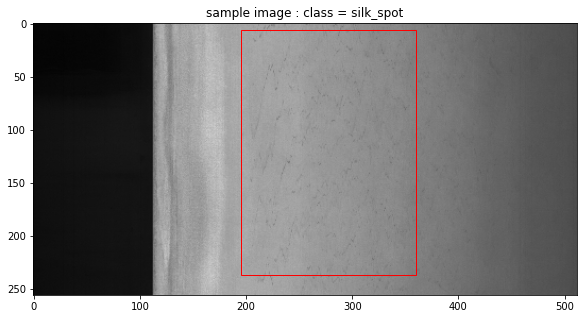

In [ ]:
for im, label in train_dataset.take(1):
    
    defect_type, xmin, xmax, ymin, ymax = label 
    
    xmin = xmin[0].numpy()/2048 * CFG.img_size[1]
    xmax = xmax[0].numpy()/2048 * CFG.img_size[1]
    ymin = ymin[0].numpy()/1000 * CFG.img_size[0]
    ymax = ymax[0].numpy()/1000 * CFG.img_size[0]
    
    fig,ax = plt.subplots(figsize = (10,5))

    rect = Rectangle((xmin, ymin),
                     (xmax - xmin),
                     (ymax - ymin), 
                     fill = False, 
                     color = "r")  
    ax.axes.add_patch(rect)
    
    plt.title(f'sample image : class = {int_2_class[defect_type[0].numpy()]}')    
    plt.imshow(im[0], cmap='gray')

## 1.2. Training

In [ ]:
def conv_block(input_layer,
               filters,
               name,
               size=3, 
               strides=2, 
               activation=tf.keras.layers.ReLU):
    
    conv = tf.keras.layers.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False, 
                                  name=f'conv_block_{name}')(input_layer)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = activation()(conv)
    conv = tf.keras.layers.MaxPooling2D()(conv)

    return conv


def dense_block(input_layer,
               units,
               name, 
               activation=tf.keras.layers.ReLU):
    
    x = tf.keras.layers.Dense(units=units, name=f'dense_block_{name}')(input_layer)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation()(x)

    return x

In [ ]:
class model_config:
    
    conv_units = [32,64,128,256]                  # размер фильтров для сверточных слоев
    filter_size= [(5,5),(3,3),(3,3),(3,3)]
    strides = [2,1,1,1]
    
    dense_units = [512,256]

In [ ]:
def build_model(model_config):
    
    # --------------Сверточные слои
    inp = tf.keras.layers.Input(shape = CFG.img_size)
    
    x = conv_block(input_layer = inp,
                   filters = model_config.conv_units[0],
                   name = 0,
                   size=model_config.filter_size[0], 
                   strides=model_config.strides[0])

    
    for num, conv_layer in enumerate(model_config.conv_units[1:], start = 1):
        
        x = conv_block(x,
                       model_config.conv_units[num],
                       num,
                       model_config.filter_size[num],
                       model_config.strides[num])
        
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # ---------------Полносвязанные слои 
    # определение координат bounding box 
    x1 = dense_block(input_layer = x, units = model_config.dense_units[1], name = 1)

    xmin = tf.keras.layers.Dense(units = 1, name = 'xmin')(x1)
    xmax = tf.keras.layers.Dense(units = 1, name = 'xmax')(x1)
    ymin = tf.keras.layers.Dense(units = 1, name = 'ymin')(x1)
    ymax = tf.keras.layers.Dense(units = 1, name = 'ymax')(x1)

    # определение типа дефекта
    x2 = dense_block(input_layer= x, units = model_config.dense_units[1], name = 2)

    class_out = tf.keras.layers.Dense(units=CFG.num_classes, name='class_out', activation='softmax')(x2)
    
    return tf.keras.Model(inputs = inp, outputs = [class_out,xmin,xmax,ymin,ymax])

In [ ]:
baseline_model = build_model(model_config)

baseline_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block_0 (Conv2D)          (None, 126, 254, 32  2400        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 126, 254, 32  128        ['conv_block_0[0][0]']           
 rmalization)                   )                                                             

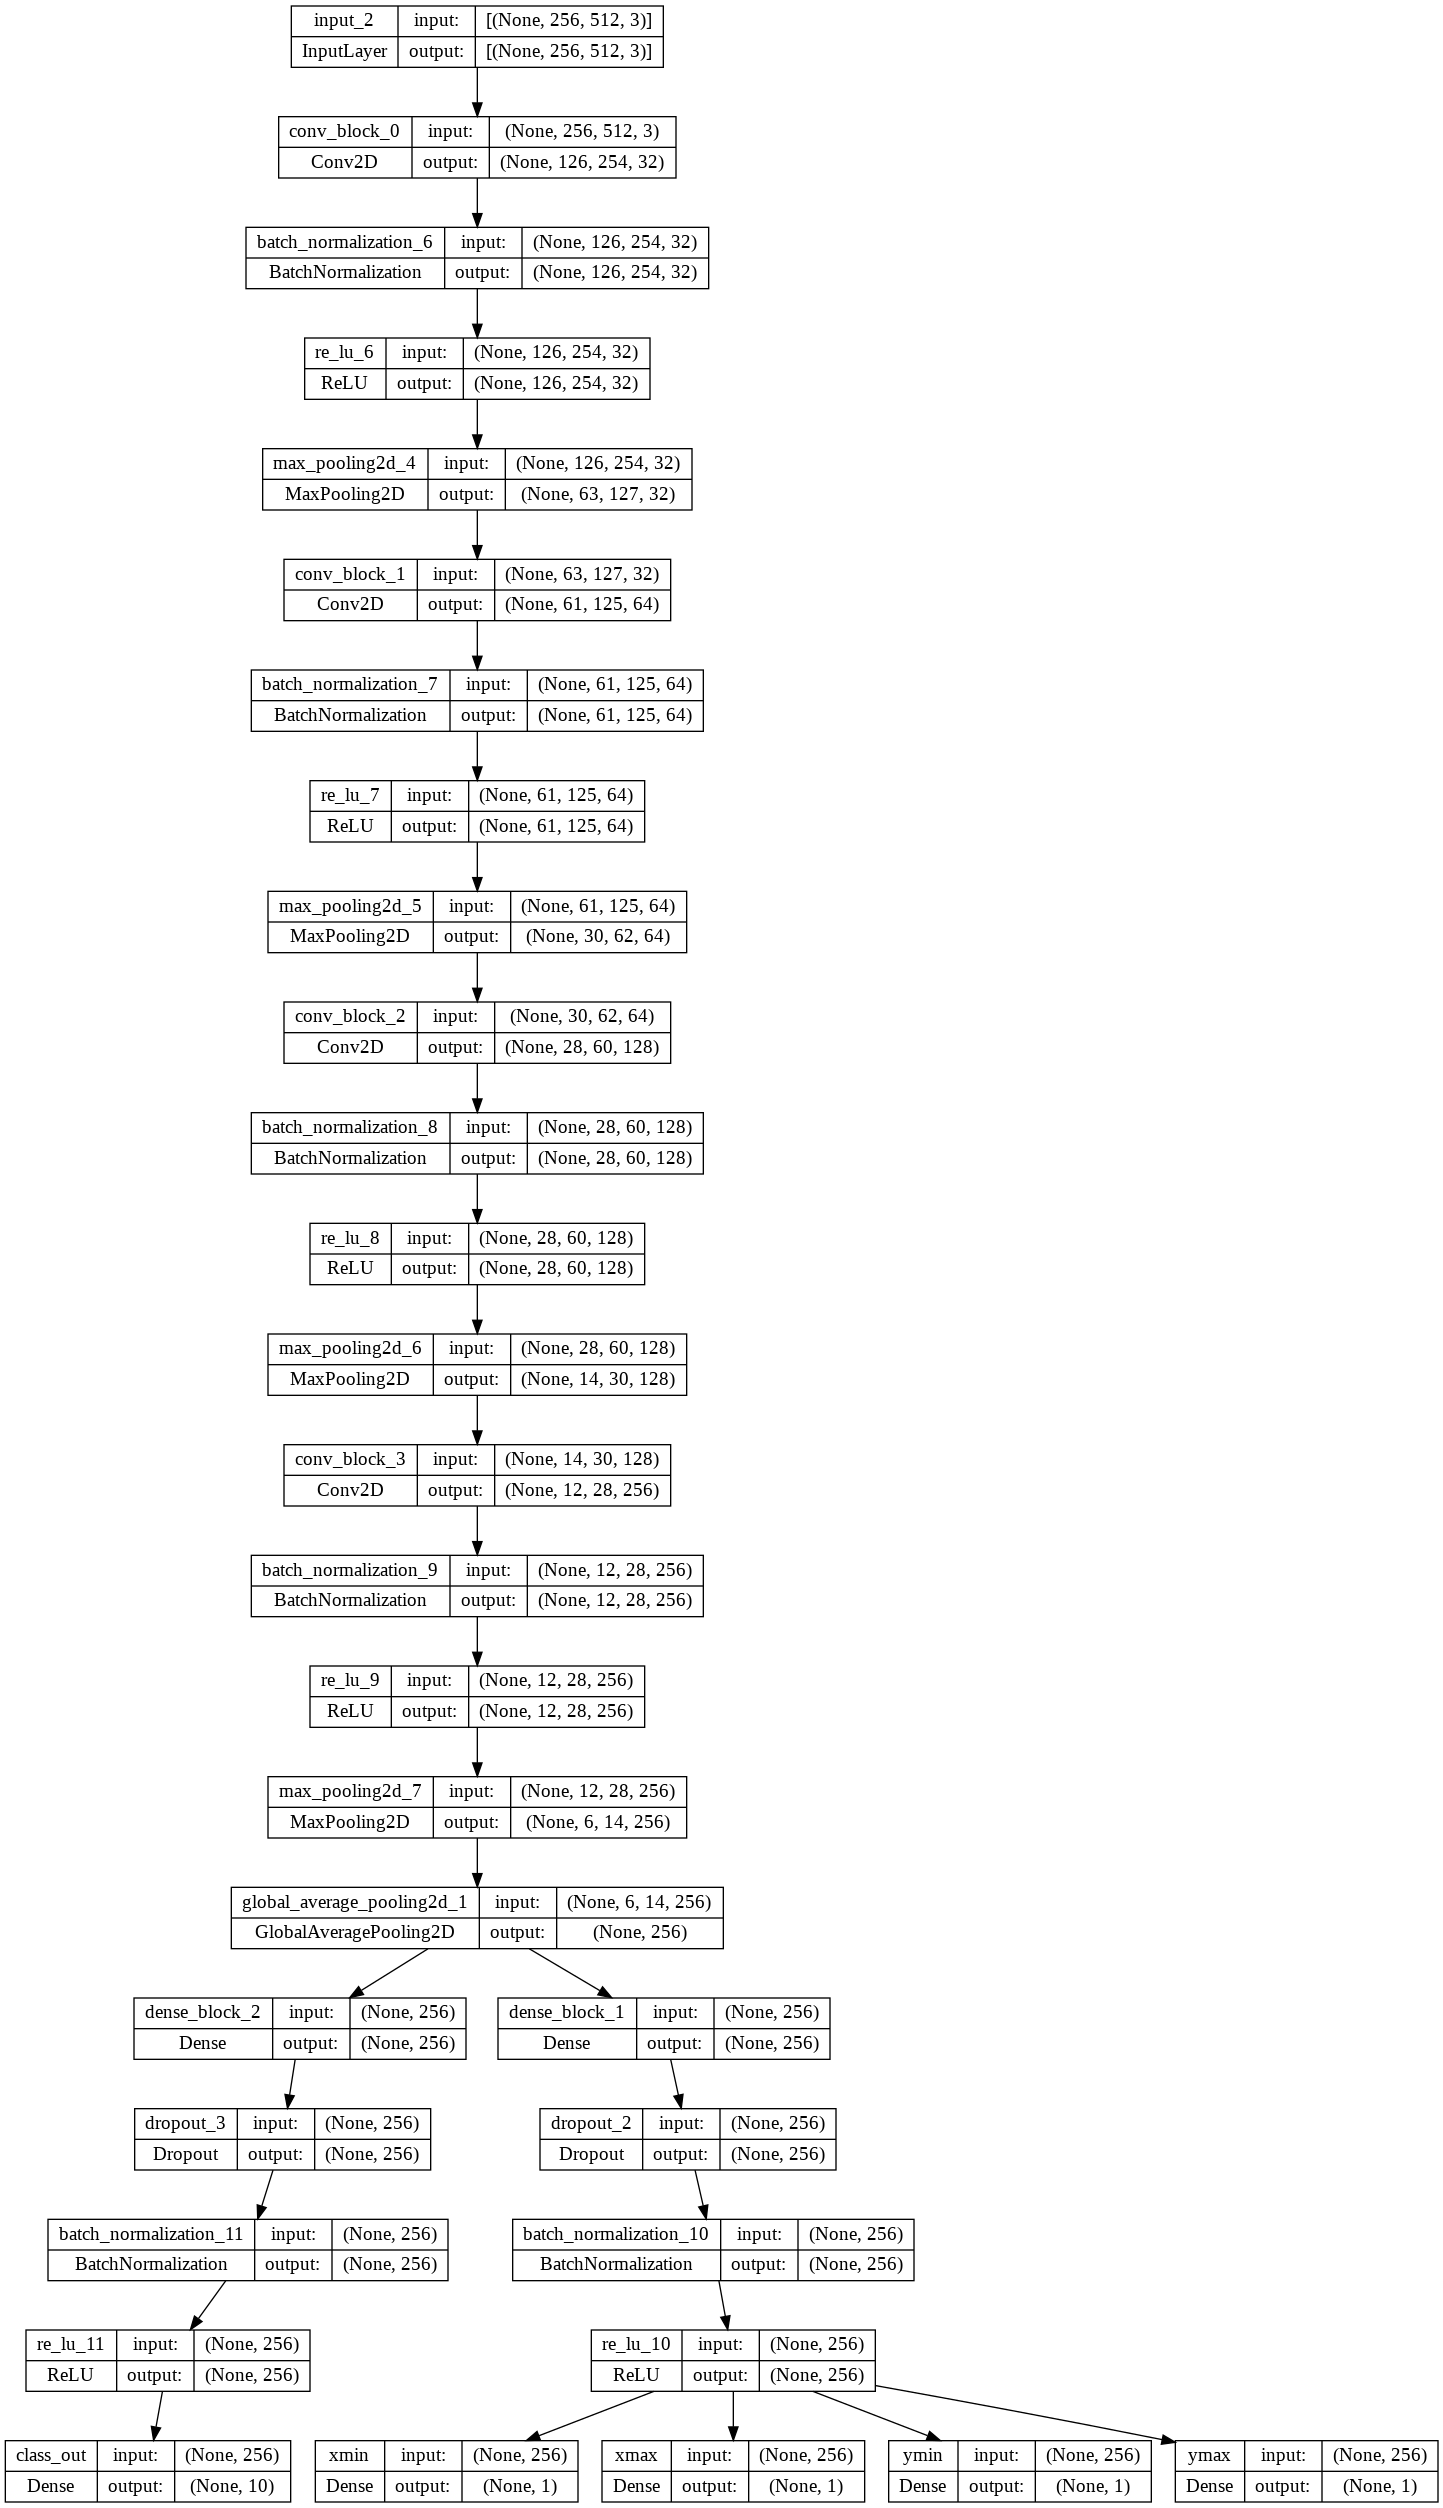

In [ ]:
tf.keras.utils.plot_model(baseline_model, show_shapes=True)

In [ ]:
def plot_history(history):
    '''
    Inputs
    history: history object from tensorflow
    add_metric: metric name in the history (like f1_score)'''
    his=pd.DataFrame(history.history)

    plt.subplots(1,2,figsize=(20,8))
    
    #loss:
    ax1=plt.subplot(1,2,1)
    ax1.plot(range(len(his)),his['loss'],color='g',label='training')
    ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    ax1.set_xlabel('EPOCHS')
    ax1.set_ylabel('LOSS')
    ax1.legend()
    ax1.set_title('Loss Per Epoch')

    #accuracy
    ax2=plt.subplot(1,2,2)
    ax2.plot(range(len(his)),his['class_out_accuracy'],color='g',label='training_acc')
    ax2.plot(range(len(his)),his['val_class_out_accuracy'],color='r',label='validation_acc')
    ax2.set_xlabel('EPOCHS')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Accuracy Per Epoch')
    
    plt.show()  

In [ ]:
baseline_model.compile(loss = {'class_out':'sparse_categorical_crossentropy',
                              'xmin':'mae',
                              'xmax':'mae',
                              'ymin':'mae',
                              'ymax':'mae'},
                       optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                       metrics = {'class_out':['accuracy']})

In [ ]:
# callbacks 
#reduce_learning rate
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(patience=2,
                                                factor=0.75,
                                                min_delta=1e-2,
                                                monitor='val_loss',
                                                verbose=1,
                                                mode='min')

#early stopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=10,
                                              min_delta=1e-2,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              mode='min')


# exponential decay 
def lr_scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.02)
    

learning_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
callbacks_1= [reduce_lr, early_stopping, learning_scheduler]

In [ ]:
# number of steps per epoch
train_steps = len(train_df) // CFG.BATCH_SIZE
val_steps = len(val_df) // CFG.BATCH_SIZE

train_steps,val_steps

(45, 11)

In [ ]:
history = baseline_model.fit(train_dataset,
                             validation_data = val_dataset,
                             epochs = 50,
                             callbacks = callbacks_1,
                             verbose=1)

Epoch 1/50
45/45 [==============================] - 37s 722ms/step - loss: 3013.3242 - class_out_loss: 2.1459 - xmin_loss: 783.0837 - xmax_loss: 1291.5698 - ymin_loss: 276.3883 - ymax_loss: 660.1370 - class_out_accuracy: 0.2472 - val_loss: 2970.3740 - val_class_out_loss: 2.1883 - val_xmin_loss: 767.2787 - val_xmax_loss: 1278.3188 - val_ymin_loss: 270.9848 - val_ymax_loss: 651.6035 - val_class_out_accuracy: 0.2159 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 34s 729ms/step - loss: 2990.4570 - class_out_loss: 1.9952 - xmin_loss: 779.5290 - xmax_loss: 1285.9283 - ymin_loss: 270.2829 - ymax_loss: 652.7212 - class_out_accuracy: 0.2632 - val_loss: 2960.4490 - val_class_out_loss: 2.2217 - val_xmin_loss: 757.3320 - val_xmax_loss: 1277.4419 - val_ymin_loss: 270.5445 - val_ymax_loss: 652.9090 - val_class_out_accuracy: 0.2415 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - 41s 879ms/step - loss: 2963.6355 - class_out_loss: 1.9474 - xmin_loss: 773.8741 - xmax_l

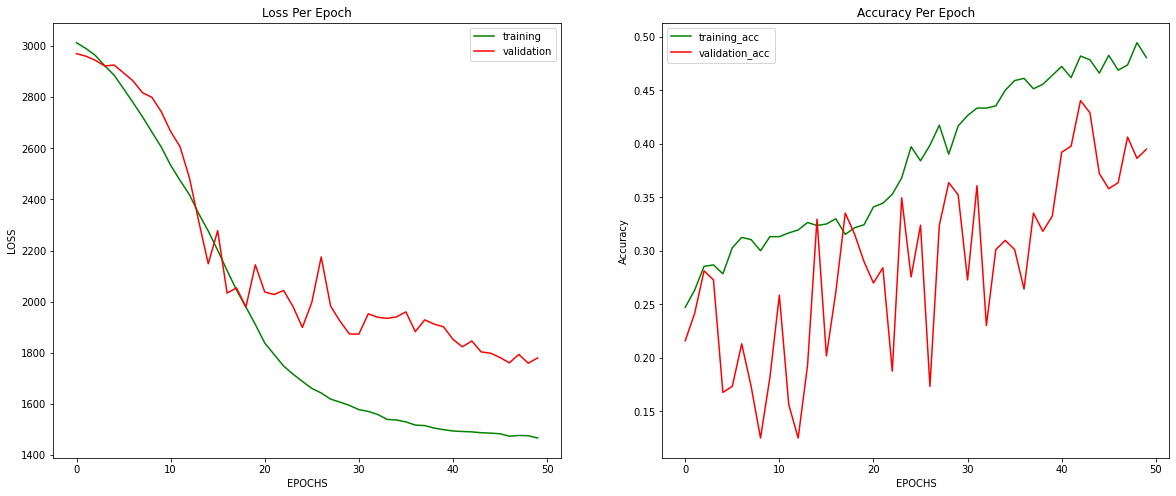

In [ ]:
plot_history(history)

In [ ]:
baseline_model.save('/content/drive/MyDrive/Project/baselinemodel.h5')

In [ ]:
from tensorflow import keras
baseline_model = keras.models.load_model('/content/drive/MyDrive/Project/baselinemodel.h5')

In [ ]:
test_ds = get_dataset(df = test_df, shuffle = False)
_ = baseline_model.evaluate(test_ds)

14/14 [==============================] - 9s 636ms/step - loss: 1700.9293 - class_out_loss: 1.6750 - xmin_loss: 449.5237 - xmax_loss: 722.5654 - ymin_loss: 235.5902 - ymax_loss: 291.5749 - class_out_accuracy: 0.4241


In [ ]:
y_test = test_df.defect_id

test_pred,v_xmin,v_xmx,v_ymin,y_ymx = baseline_model.predict(test_ds)

print(len(y_test), len(test_pred))

14/14 [==============================] - 12s 834ms/step
456 448


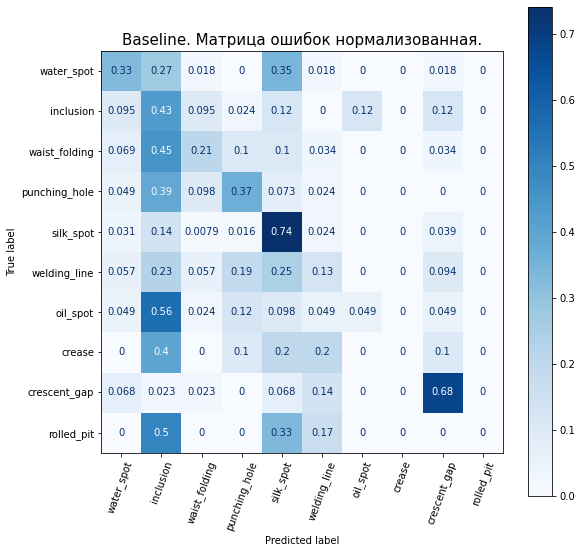

In [ ]:
cm = confusion_matrix(y_test[:len(test_pred)], test_pred.argmax(axis=1), normalize='true')   #последние записи удалены из-за пакетной обработки 
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_title('Baseline. Матрица ошибок нормализованная.', size=15)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CFG.class_dict.keys())   
disp.plot(ax=ax, cmap = 'Blues')
plt.xticks(rotation=70)
plt.show()

# 2. MobileNetV2

In [ ]:
backbone = tf.keras.applications.MobileNetV2(
                                        include_top=False,
                                        input_shape = CFG.img_size,
                                        weights='imagenet',
                                        pooling = 'avg')

backbone.trainable = False

#определение координат bounding box
x1 = dense_block(input_layer= backbone.output,units = 1024, name = 1)
x1 = dense_block(input_layer= x1,units = 512, name = 12)

xmin = tf.keras.layers.Dense(units = 1,name = 'xmin')(x1)
xmax = tf.keras.layers.Dense(units = 1,name = 'xmax')(x1)
ymin = tf.keras.layers.Dense(units = 1,name = 'ymin')(x1)
ymax = tf.keras.layers.Dense(units = 1,name = 'ymax')(x1)


#определение типа дефекта
x2 = dense_block(input_layer= backbone.output,units = 512, name = 21)
x2 = dense_block(input_layer= x2,units = model_config.dense_units[0], name = 22)

class_out = tf.keras.layers.Dense(units = CFG.num_classes, name = 'class_out', activation='softmax')(x2)


mobilenet_model =  tf.keras.Model(inputs = backbone.input,
                      outputs = [class_out,xmin,xmax,ymin,ymax])


mobilenet_model.compile(loss = {'class_out':'sparse_categorical_crossentropy',
                              'xmin':'mae',
                              'xmax':'mae',
                              'ymin':'mae',
                              'ymax':'mae',},
                       optimizer = tf.keras.optimizers.Adam(lr = 0.001),
                       metrics = {'class_out':['accuracy']})

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
mobilenet_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 256, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 256, 32  128         ['Conv1[0][0]']                  
                                )                                                           

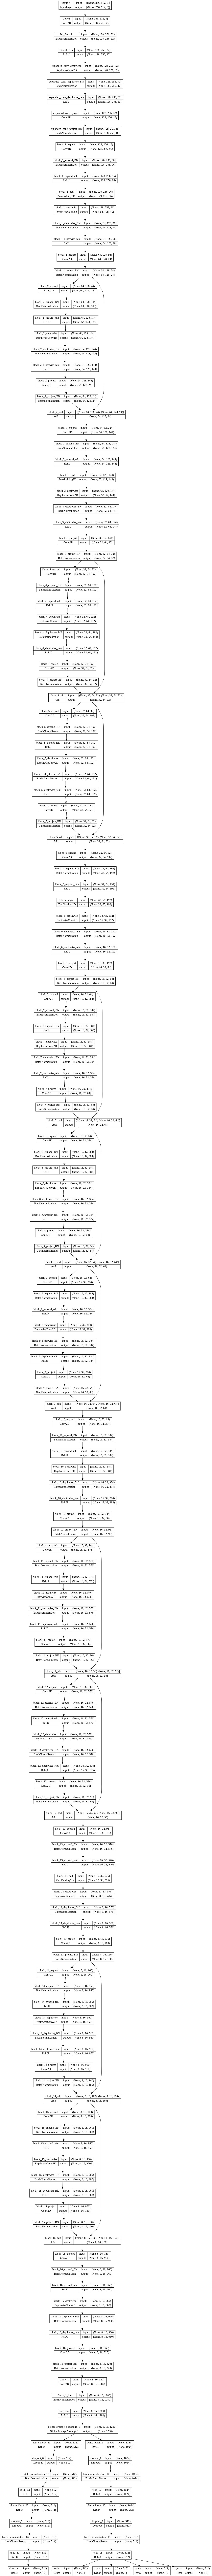

In [ ]:
tf.keras.utils.plot_model(mobilenet_model, show_shapes=True)

In [ ]:
history2 = mobilenet_model.fit(train_dataset,
                              validation_data = val_dataset,
                              epochs = 50,
                              callbacks = callbacks_1,
                              verbose=1)

Epoch 1/50
45/45 [==============================] - 42s 805ms/step - loss: 3005.5898 - class_out_loss: 1.5587 - xmin_loss: 783.2823 - xmax_loss: 1288.2880 - ymin_loss: 274.1929 - ymax_loss: 658.2678 - class_out_accuracy: 0.4667 - val_loss: 2907.6094 - val_class_out_loss: 1.0531 - val_xmin_loss: 743.1984 - val_xmax_loss: 1268.6024 - val_ymin_loss: 259.9411 - val_ymax_loss: 634.8144 - val_class_out_accuracy: 0.6562 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 41s 881ms/step - loss: 2952.4968 - class_out_loss: 1.0622 - xmin_loss: 768.0958 - xmax_loss: 1272.9596 - ymin_loss: 265.4831 - ymax_loss: 644.8961 - class_out_accuracy: 0.6403 - val_loss: 2964.0615 - val_class_out_loss: 0.8658 - val_xmin_loss: 771.1243 - val_xmax_loss: 1283.0165 - val_ymin_loss: 263.9247 - val_ymax_loss: 645.1301 - val_class_out_accuracy: 0.7386 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 2897.7324 - class_out_loss: 0.8732 - xmin_loss: 759.6211 - xmax_loss: 12

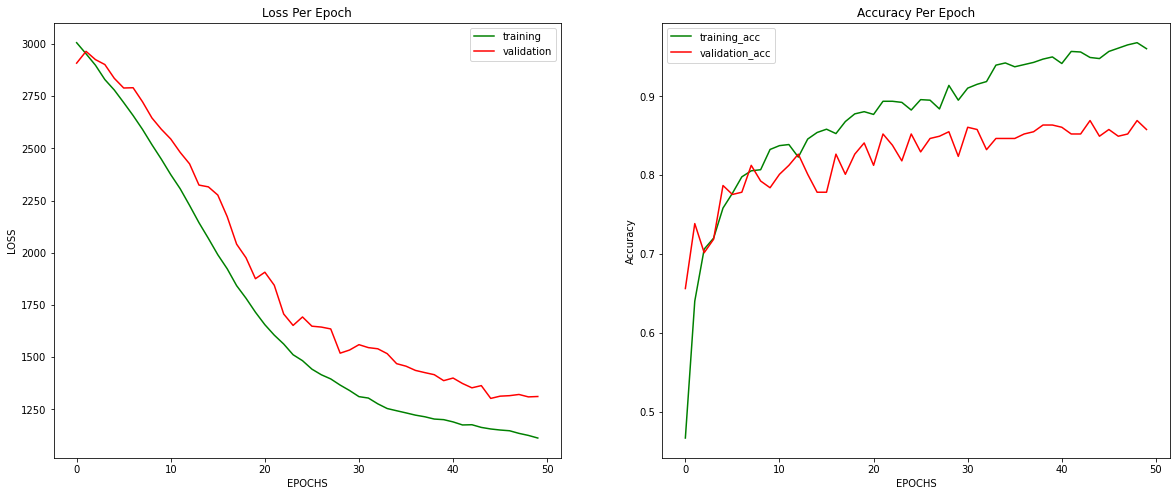

In [ ]:
plot_history(history2)

In [ ]:
mobilenet_model.save('/content/drive/MyDrive/Project/mobilenetmodel.h5')

In [ ]:
from tensorflow import keras
mobilenet_model = keras.models.load_model('/content/drive/MyDrive/Project/mobilenetmodel.h5')

In [ ]:
test_ds = get_dataset(df = test_df, shuffle = False)
_ = mobilenet_model.evaluate(test_ds)

14/14 [==============================] - 36s 2s/step - loss: 1311.3955 - class_out_loss: 0.4833 - xmin_loss: 425.2002 - xmax_loss: 426.5844 - ymin_loss: 203.3208 - ymax_loss: 255.8069 - class_out_accuracy: 0.8549


In [ ]:
y_test = test_df.defect_id

test_pred,v_xmin,v_xmx,v_ymin,y_ymx = mobilenet_model.predict(test_ds)

print(len(y_test), len(test_pred))

14/14 [==============================] - 10s 651ms/step
456 448


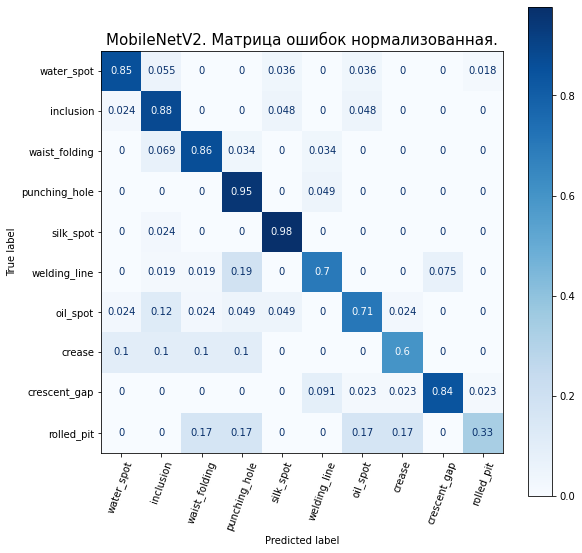

In [ ]:
cm = confusion_matrix(y_test[:len(test_pred)], test_pred.argmax(axis=1), normalize='true')   #последние записи удалены из-за пакетной обработки 
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_title('MobileNetV2. Матрица ошибок нормализованная.', size=15)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CFG.class_dict.keys())   
disp.plot(ax=ax, cmap = 'Blues')
plt.xticks(rotation=70)
plt.show()

# 3. MobileNetV2. Один дефект на изображении.

## 3.1. Предобработка данных

Заметим, что на одном изображении может быть несколько дефектов (несколько bounding boxes). Сохраним все bounding boxes (не только первые, как было сделано выше).

In [ ]:
def read_xml_2(path):
    '''read the xml label file to get the bounding box'''
    
    d = {}
    
    d['file_id'] = path.rsplit('/',1)[1].split('.')[0]
    
    with open(path) as f:
        
        xml_f = etree.HTML(f.read())
        
    d["width"] = int(xml_f.xpath("//size/width/text()")[0])
    d['height'] = int(xml_f.xpath("//size/height/text()")[0])  
    
    d["xmin"] = xml_f.xpath("//bndbox/xmin/text()")
    d['xmax'] = xml_f.xpath("//bndbox/xmax/text()")
    d['ymin'] = xml_f.xpath("//bndbox/ymin/text()")
    d['ymax'] = xml_f.xpath("//bndbox/ymax/text()")

    d['defect_class_2'] = xml_f.xpath("//object/name/text()")
    
    return d

In [ ]:
img_metadata = []

for label in tqdm(label_paths):
    imageinfo = read_xml_2(label)
    
    file_id = imageinfo['file_id']
    imageinfo['image_path'] = glob(f'{image_dir}*/{file_id}.jpg')[0]
    
    imageinfo['defect_class'] = imageinfo['image_path'].rsplit('/',2)[1]
    img_metadata.append(imageinfo)
    
df = pd.DataFrame.from_records(img_metadata) 

100%|██████████| 2280/2280 [00:56<00:00, 40.13it/s] 


В xml файлах к каждому боксу есть object name. Сохраним данные названия и попробуем соотнести их с названиями дефектов.

In [ ]:
defects_name = []
for dft in list(df.defect_class_2.values):
  defects_name.extend(dft)

set(defects_name)

{'10_yaozhe',
 '10_yaozhed',
 '1_chongkong',
 '2_hanfeng',
 '3_yueyawan',
 '4_shuiban',
 '5_youban',
 '6_siban',
 '7_yiwu',
 '8_yahen',
 '9_zhehen',
 'd'}

In [ ]:
defects_name = []
for i, dft in enumerate(list(df.defect_class_2.values)):
  if 'd' in dft:
    print(i)

1363


In [ ]:
df[df.index==1363]

file_id  width  height       xmin          xmax  \
1363  img_02_425616500_00770   2048    1000  [3, 1997]  [2048, 2048]   

           ymin        ymax  defect_class_2  \
1363  [83, 257]  [154, 310]  [2_hanfeng, d]   

                                             image_path  defect_class  
1363  drive/MyDrive/Project/data/images/images/weldi...  welding_line

In [ ]:
df['defect_class_str'] = df.defect_class_2.astype(str)

In [ ]:
df.defect_class.value_counts()

silk_spot        649
water_spot       287
welding_line     267
crescent_gap     224
punching_hole    215
inclusion        211
oil_spot         204
waist_folding    144
crease            51
rolled_pit        28
Name: defect_class, dtype: int64

In [ ]:
df['box_count'] = df['xmin'].apply(lambda x: 1 if len(x)==1 else 0)
df[df.box_count==1].shape

(1489, 11)

In [ ]:
df[df.box_count==1].defect_class.value_counts()

silk_spot        568
water_spot       243
waist_folding    142
welding_line     142
inclusion        104
crescent_gap      99
oil_spot          71
punching_hole     71
crease            35
rolled_pit        14
Name: defect_class, dtype: int64

Построим словарь, который показывает соотношение названий дефектов из папок (по которым распределены изображения) и информации из xml-файлов:

In [ ]:
corresp_dict = defaultdict(list)
for cl1, cl2 in zip(df[df.box_count==1].defect_class.values, df[df.box_count==1].defect_class_2.values):
  corresp_dict[cl1].append(cl2[0])

for key, item in corresp_dict.items():
  corresp_dict[key] = list(set(item))
corresp_dict

defaultdict(list,
            {'water_spot': ['5_youban', '4_shuiban'],
             'inclusion': ['4_shuiban', '6_siban', '7_yiwu'],
             'waist_folding': ['9_zhehen',
              '10_yaozhe',
              '7_yiwu',
              '10_yaozhed'],
             'silk_spot': ['5_youban', '6_siban'],
             'welding_line': ['1_chongkong', '2_hanfeng'],
             'crease': ['9_zhehen', '8_yahen', '4_shuiban'],
             'oil_spot': ['5_youban', '4_shuiban', '7_yiwu'],
             'crescent_gap': ['3_yueyawan'],
             'punching_hole': ['1_chongkong'],
             'rolled_pit': ['8_yahen', '7_yiwu']})

In [ ]:
df[df.box_count==1].defect_class_str.unique()

array(["['4_shuiban']", "['7_yiwu']", "['10_yaozhed']", "['6_siban']",
       "['2_hanfeng']", "['9_zhehen']", "['5_youban']", "['3_yueyawan']",
       "['1_chongkong']", "['8_yahen']", "['10_yaozhe']"], dtype=object)

In [ ]:
len(df[(df.defect_class=='water_spot')&(df.defect_class_str=="['4_shuiban']")])

224

In [ ]:
len(df[(df.defect_class=='water_spot')&(df.defect_class_str=="['5_youban']")])

19

Видим, что однозначно определить класс дефекта на основании информации из xml-файлов невозможно. То есть нет возможности определить классы дефектов для изображений с несколькими дефектами. Поэтому оставим только те изображения, на которых только один дефект (чтобы однозначно определить класс дефекта на основании названия папки, в котором сохранено изображение).

In [ ]:
df = df[df.box_count==1].reset_index(drop=True)
df.drop(columns=['box_count'], inplace=True)
df.shape

(1489, 10)

In [ ]:
df['xmin'] = df['xmin'].apply(lambda x: int(x[0]))
df['xmax'] = df['xmax'].apply(lambda x: int(x[0]))
df['ymin'] = df['ymin'].apply(lambda x: int(x[0]))
df['ymax'] = df['ymax'].apply(lambda x: int(x[0]))

In [ ]:
#сохранение словаря "название класса": "номер класса" в config
CFG.class_dict = {val: idx for idx, val in enumerate(df.defect_class.unique())}
CFG.num_classes = len(CFG.class_dict)

#inverse mapping dictionary 
int_2_class = {idx: clss for clss, idx in CFG.class_dict.items()}

CFG.class_dict

{'water_spot': 0,
 'inclusion': 1,
 'waist_folding': 2,
 'silk_spot': 3,
 'welding_line': 4,
 'crease': 5,
 'oil_spot': 6,
 'crescent_gap': 7,
 'punching_hole': 8,
 'rolled_pit': 9}

In [ ]:
df['defect_id'] = df['defect_class'].map(CFG.class_dict)

df['width'].unique(),df['height'].unique()

(array([2048]), array([1000]))

In [ ]:
df.head()

file_id  width  height  xmin  xmax  ymin  ymax  \
0  img_03_4405000700_00831   2048    1000   876  1007   144   973   
1  img_04_4402622500_00355   2048    1000  1044  1090   334   373   
2  img_06_3436639700_00756   2048    1000  1453  1958   134   827   
3  img_08_4403744200_01180   2048    1000     1   308     1   664   
4   img_04_436068100_00089   2048    1000    25   233    55   881   

  defect_class_2                                         image_path  \
0    [4_shuiban]  drive/MyDrive/Project/data/images/images/water...   
1       [7_yiwu]  drive/MyDrive/Project/data/images/images/inclu...   
2   [10_yaozhed]  drive/MyDrive/Project/data/images/images/waist...   
3    [4_shuiban]  drive/MyDrive/Project/data/images/images/water...   
4      [6_siban]  drive/MyDrive/Project/data/images/images/silk_...   

    defect_class  defect_id  
0     water_spot          0  
1      inclusion          1  
2  waist_folding          2  
3     water_spot          0  
4      silk_spot          3

In [ ]:
df[['file_id', 'width', 'height', 'xmin', 'xmax', 'ymin', 'ymax', 'image_path', 'defect_class', 'defect_id']].head()

file_id  width  height  xmin  xmax  ymin  ymax  \
0  img_03_4405000700_00831   2048    1000   876  1007   144   973   
1  img_04_4402622500_00355   2048    1000  1044  1090   334   373   
2  img_06_3436639700_00756   2048    1000  1453  1958   134   827   
3  img_08_4403744200_01180   2048    1000     1   308     1   664   
4   img_04_436068100_00089   2048    1000    25   233    55   881   

                                          image_path   defect_class  defect_id  
0  drive/MyDrive/Project/data/images/images/water...     water_spot          0  
1  drive/MyDrive/Project/data/images/images/inclu...      inclusion          1  
2  drive/MyDrive/Project/data/images/images/waist...  waist_folding          2  
3  drive/MyDrive/Project/data/images/images/water...     water_spot          0  
4  drive/MyDrive/Project/data/images/images/silk_...      silk_spot          3

In [ ]:
df['defect_class'].unique()

array(['water_spot', 'inclusion', 'waist_folding', 'silk_spot',
       'welding_line', 'crease', 'oil_spot', 'crescent_gap',
       'punching_hole', 'rolled_pit'], dtype=object)

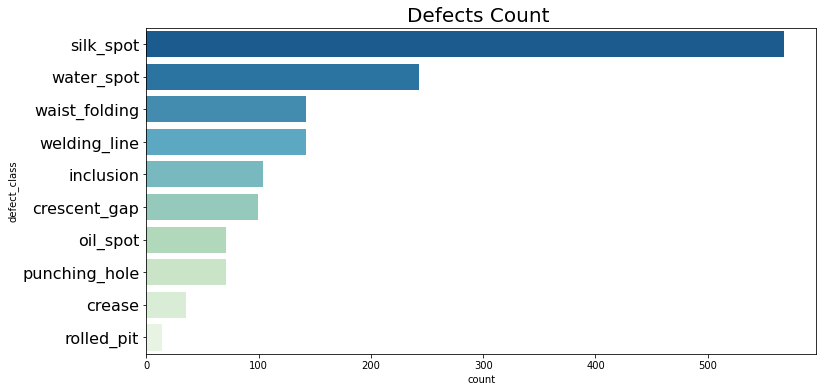

In [ ]:
plt.figure(figsize=(12,6))
plt.yticks(fontsize=16)
sns.countplot(y="defect_class",
              data=df,
              palette="GnBu_r",
              order=df['defect_class'].value_counts().index,
              linewidth=3)
plt.title("Defects Count ", size=20, color='k')
plt.show()

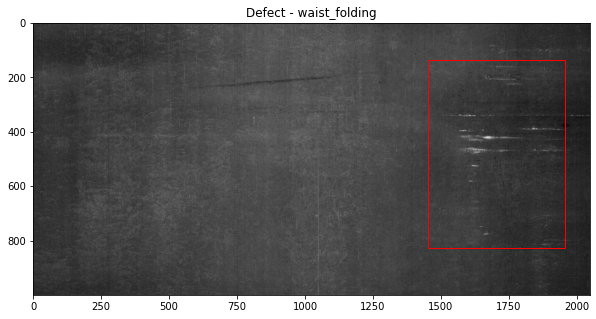

In [ ]:
plot_sample(2)

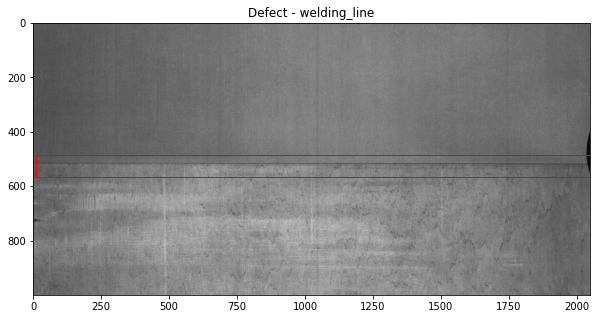

In [ ]:
plot_sample(600)

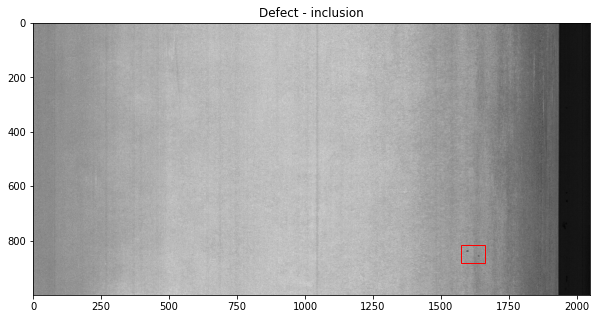

In [ ]:
plot_sample(50)

In [ ]:
train_df, test_df = train_test_split(df, test_size = 0.2, stratify = df['defect_id'], random_state=CFG.seed) 
train_df, val_df = train_test_split(train_df, test_size = 0.2, stratify = train_df['defect_id'], random_state=CFG.seed) 

print(len(train_df))
print(len(val_df))
print(len(test_df))

952
239
298


In [ ]:
train_dataset= get_dataset(df = train_df)
val_dataset= get_dataset(df = val_df)
test_dataset= get_dataset(df = test_df)

## 3.2. Обучение сети

Применим созданную ранее нейронную сеть на основании MobileNet к новому датасету:

In [ ]:
backbone = tf.keras.applications.MobileNetV2(
                                        include_top=False,
                                        input_shape = CFG.img_size,
                                        weights='imagenet',
                                        pooling = 'avg')

backbone.trainable = False

#определение координат bounding box
x1 = dense_block(input_layer= backbone.output,units = 1024, name = 1)
x1 = dense_block(input_layer= x1,units = 512, name = 12)

xmin = tf.keras.layers.Dense(units = 1,name = 'xmin')(x1)
xmax = tf.keras.layers.Dense(units = 1,name = 'xmax')(x1)
ymin = tf.keras.layers.Dense(units = 1,name = 'ymin')(x1)
ymax = tf.keras.layers.Dense(units = 1,name = 'ymax')(x1)


#определение типа дефекта
x2 = dense_block(input_layer= backbone.output,units = 512, name = 21)
x2 = dense_block(input_layer= x2,units = model_config.dense_units[0], name = 22)

class_out = tf.keras.layers.Dense(units = CFG.num_classes, name = 'class_out', activation='softmax')(x2)


mobilenet_model_2 =  tf.keras.Model(inputs = backbone.input,
                      outputs = [class_out,xmin,xmax,ymin,ymax])


mobilenet_model_2.compile(loss = {'class_out':'sparse_categorical_crossentropy',
                              'xmin':'mae',
                              'xmax':'mae',
                              'ymin':'mae',
                              'ymax':'mae',},
                       optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                       metrics = {'class_out':['accuracy']})

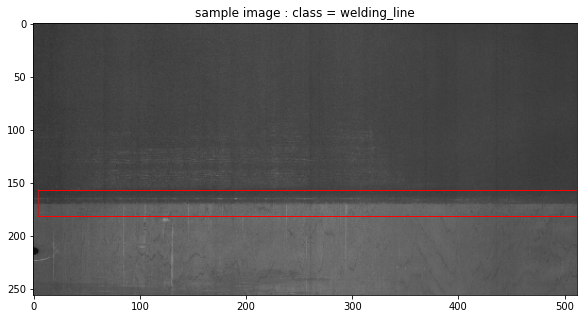

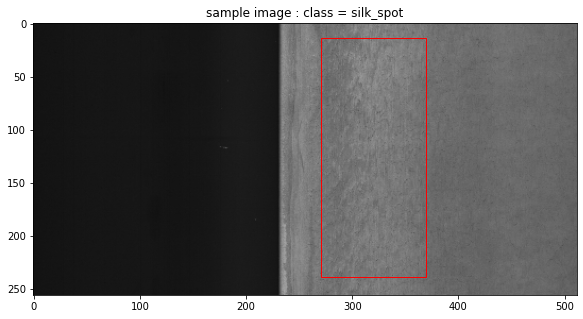

In [ ]:
for im, label in train_dataset.take(2):
    
    defect_type, xmin, xmax, ymin, ymax = label 
    
    xmin = xmin[0].numpy()/2048 * CFG.img_size[1]
    xmax = xmax[0].numpy()/2048 * CFG.img_size[1]
    ymin = ymin[0].numpy()/1000 * CFG.img_size[0]
    ymax = ymax[0].numpy()/1000 * CFG.img_size[0]
    
    fig, ax = plt.subplots(figsize = (10,5))

    rect = Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r")  
    ax.axes.add_patch(rect)
    
    plt.title(f'sample image : class = {int_2_class[defect_type[0].numpy()]}')    
    plt.imshow(im[0], cmap='gray')

In [ ]:
history3 = mobilenet_model_2.fit(train_dataset,
                              validation_data = val_dataset,
                              epochs = 50,
                              callbacks = callbacks_1,
                              verbose=1)

Epoch 1/50
29/29 [==============================] - 163s 5s/step - loss: 1113.9773 - class_out_loss: 3.8997 - xmin_loss: 345.0067 - xmax_loss: 372.0628 - ymin_loss: 184.8748 - ymax_loss: 208.1335 - class_out_accuracy: 0.4957 - val_loss: 1397.5510 - val_class_out_loss: 1.5191 - val_xmin_loss: 442.5543 - val_xmax_loss: 535.7928 - val_ymin_loss: 183.3649 - val_ymax_loss: 234.3201 - val_class_out_accuracy: 0.6607 - lr: 1.5907e-04
Epoch 2/50
29/29 [==============================] - 25s 807ms/step - loss: 1105.5317 - class_out_loss: 0.8293 - xmin_loss: 347.7305 - xmax_loss: 367.9731 - ymin_loss: 187.1272 - ymax_loss: 201.8715 - class_out_accuracy: 0.7705 - val_loss: 1400.8854 - val_class_out_loss: 0.9121 - val_xmin_loss: 442.7227 - val_xmax_loss: 544.3282 - val_ymin_loss: 183.0315 - val_ymax_loss: 229.8908 - val_class_out_accuracy: 0.7232 - lr: 1.5907e-04
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 1105.0481 - class_out_loss: 0.6099 - xmin_loss: 349.3312 - xmax_loss: 

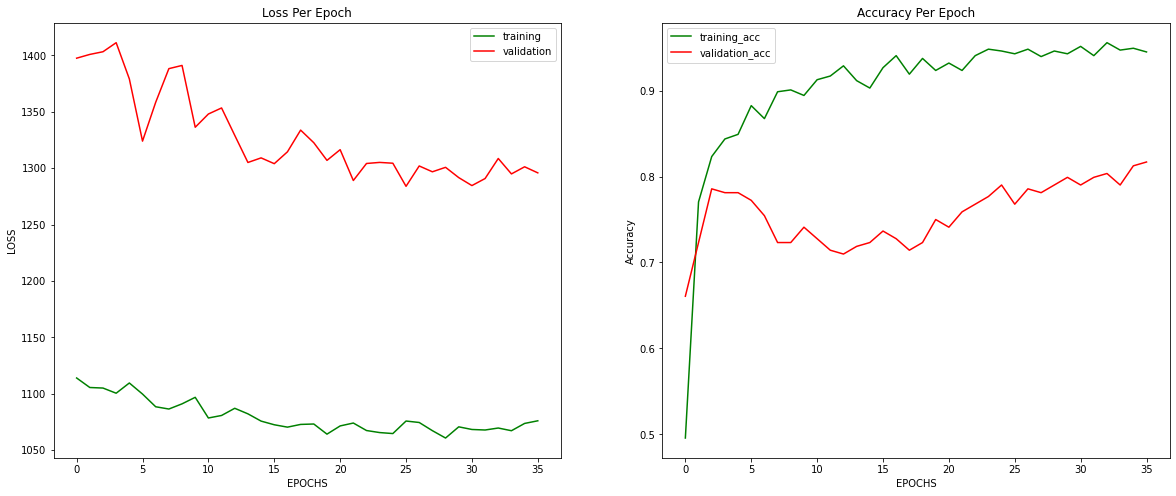

In [ ]:
plot_history(history3)

In [ ]:
mobilenet_model_2.save('/content/drive/MyDrive/Project/mobilenetmodel_2.h5')

In [ ]:
from tensorflow import keras
mobilenet_model_2 = keras.models.load_model('/content/drive/MyDrive/Project/mobilenetmodel_2.h5')

In [ ]:
test_ds = get_dataset(df = test_df, shuffle = False)
_ = mobilenet_model_2.evaluate(test_ds)

9/9 [==============================] - 75s 7s/step - loss: 1291.6506 - class_out_loss: 0.6543 - xmin_loss: 409.3809 - xmax_loss: 461.4742 - ymin_loss: 191.5226 - ymax_loss: 228.6186 - class_out_accuracy: 0.7917


In [ ]:
y_test = test_df.defect_id

test_pred,v_xmin,v_xmx,v_ymin,y_ymx = mobilenet_model_2.predict(test_ds)

print(len(y_test), len(test_pred))

9/9 [==============================] - 6s 632ms/step
298 288


In [ ]:
test_ds_2 = test_ds.unbatch()
images = list(test_ds_2.map(lambda x, y: x))
labels = list(test_ds_2.map(lambda x, y: y))

In [ ]:
labels[0]

(<tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1371>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2048>,
 <tf.Tensor: shape=(), dtype=int64, numpy=39>,
 <tf.Tensor: shape=(), dtype=int64, numpy=959>)

In [ ]:
test_df.head()

file_id  width  height  xmin  xmax  ymin  ymax  \
1254   img_06_436185800_00735   2048    1000  1371  2048    39   959   
11    img_07_4405381400_00779   2048    1000    36  2012   209   340   
542   img_07_4406645900_00559   2048    1000  1764  1917    81   325   
174   img_05_4406743300_00482   2048    1000  1026  1326   148   903   
567   img_05_4406743300_00614   2048    1000   967  1207    94   971   

     defect_class_2                                         image_path  \
1254   [10_yaozhed]  drive/MyDrive/Project/data/images/images/waist...   
11       [9_zhehen]  drive/MyDrive/Project/data/images/images/creas...   
542       [6_siban]  drive/MyDrive/Project/data/images/images/silk_...   
174       [6_siban]  drive/MyDrive/Project/data/images/images/silk_...   
567       [6_siban]  drive/MyDrive/Project/data/images/images/silk_...   

       defect_class defect_class_str  defect_id  
1254  waist_folding   ['10_yaozhed']          2  
11           crease     ['9_zhehen']          5  
542       silk_spot      ['6_siban']          3  
174       silk_spot      ['6_siban']          3  
567       silk_spot      ['6_siban']          3

In [ ]:
pred_list = []
for cl, xmin, xmax, ymin, ymax in zip(test_pred,v_xmin,v_xmx,v_ymin,y_ymx):
  pred_list.append([cl.argmax(), cl[cl.argmax()], xmin[0], xmax[0], ymin[0], ymax[0]])

In [ ]:
pred_list[:10]

[[2, 0.9949274, 718.9006, 1105.5641, 125.50605, 760.6257],
 [7, 0.62120473, 534.96716, 840.928, 106.85229, 582.5008],
 [2, 0.39339548, 962.9425, 1407.765, 152.8657, 954.44885],
 [3, 0.6869468, 746.97473, 1111.4318, 123.64843, 759.2934],
 [3, 0.3298402, 733.2008, 1099.3701, 131.33058, 752.1885],
 [3, 0.39658135, 461.42575, 727.82416, 104.90817, 505.5281],
 [7, 0.60520774, 475.0027, 768.29584, 87.63148, 536.7676],
 [4, 0.6235268, 509.32706, 824.0509, 94.14753, 575.7062],
 [5, 0.66133124, 477.56885, 772.749, 91.77159, 540.0543],
 [1, 0.99741495, 816.64514, 1202.5034, 129.85088, 816.66565]]

In [ ]:
# функция для вывода изображения и предсказанной и фактической рамок

def prediction_show(i):
    
    ##################################### Предсказания ##########################################
    pred = pred_list[i]
    defect_type = pred[0]
    score = np.round(pred[1], 2) 
    xmin = pred[2]
    xmax = pred[3]
    ymin = pred[4]
    ymax = pred[5]
    

    fig, axs = plt.subplots(1, 2, figsize=(15, 12))

    rect = Rectangle((xmin, ymin),(xmax - xmin),(ymax - ymin),fill = False,color = "r")  
    axs[0].axes.add_patch(rect)
    axs[0].set_title(f'Defect: {int_2_class[defect_type]}. Score: {str(score)}') 
    axs[0].imshow(plt.imread(test_df['image_path'].iloc[i]), cmap = 'gray')

    ##################################### Оригинальное ##########################################

    defect_type_2 = test_df['defect_class'].iloc[i]
    xmin_2 = test_df['xmin'].iloc[i]
    xmax_2 = test_df['xmax'].iloc[i]
    ymin_2 = test_df['ymin'].iloc[i]
    ymax_2 = test_df['ymax'].iloc[i]
    
    rect = Rectangle((xmin_2, ymin_2),(xmax_2 - xmin_2),(ymax_2 - ymin_2),fill = False,color = "r")   
    axs[1].axes.add_patch(rect)
    axs[1].set_title(f'Defect: {defect_type_2}') 
    axs[1].imshow(plt.imread(test_df['image_path'].iloc[i]), cmap = 'gray')

In [ ]:
test_df_2 = test_df[:len(test_pred)].copy()
test_df_2 = test_df_2.reset_index()

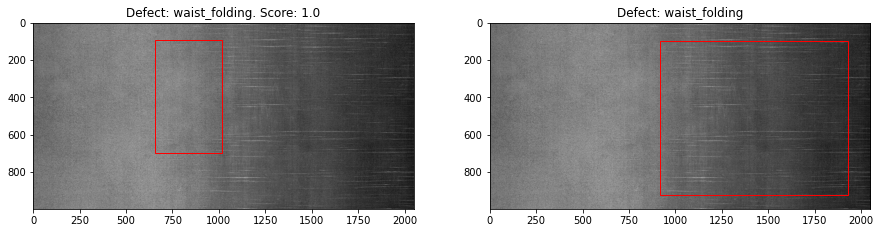

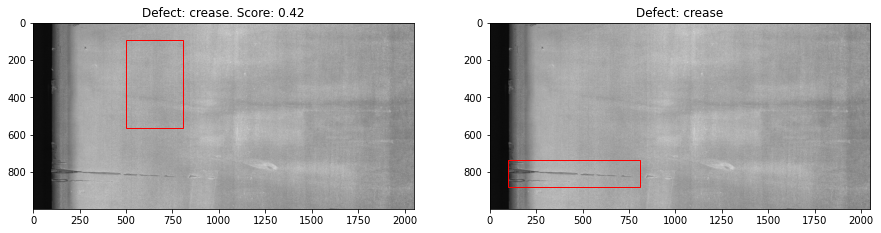

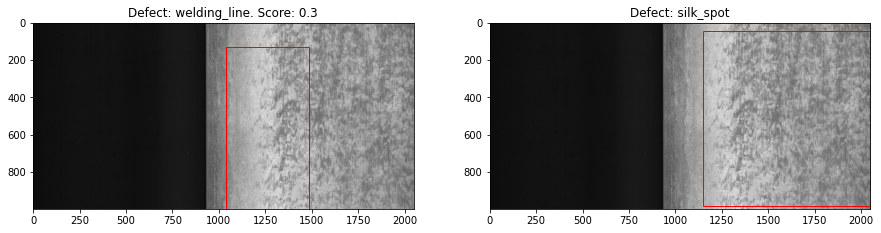

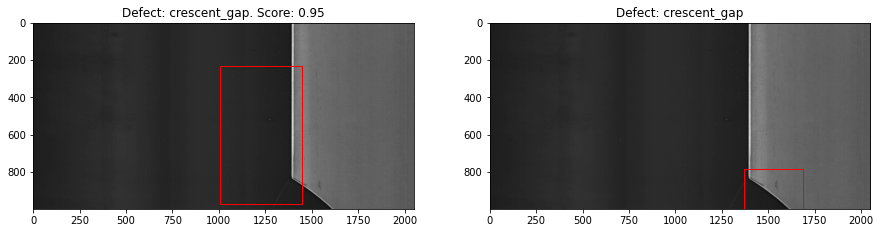

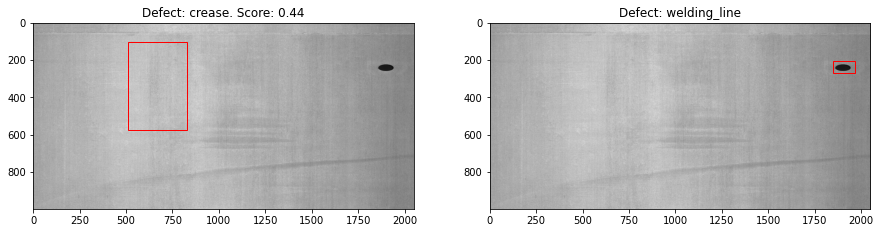

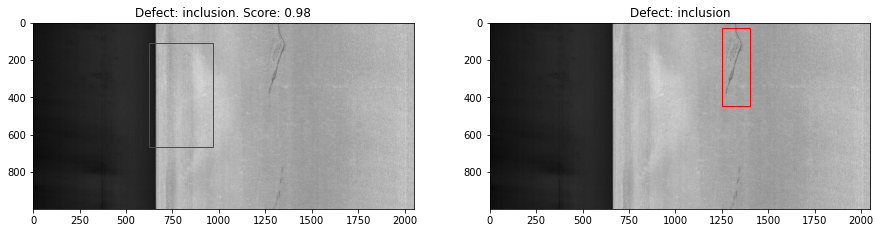

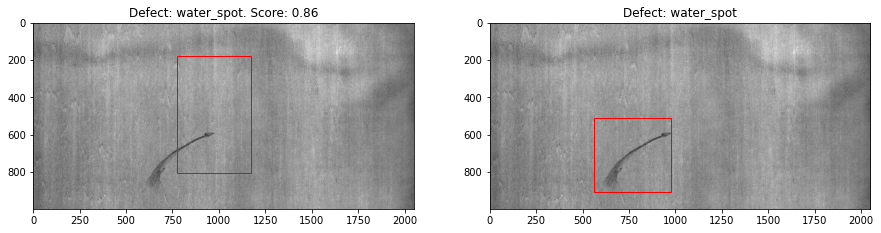

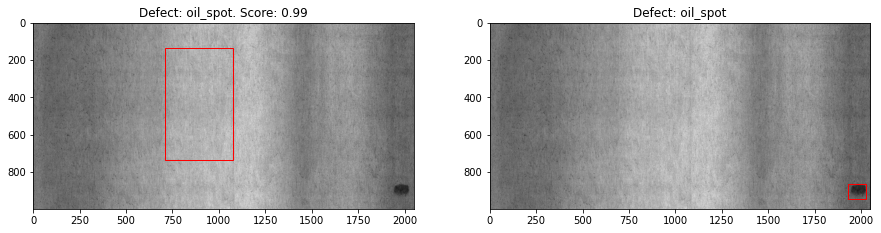

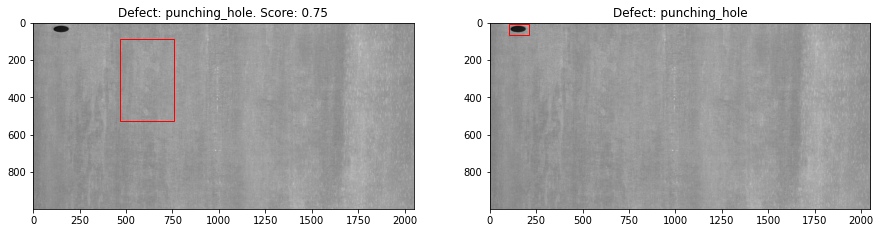

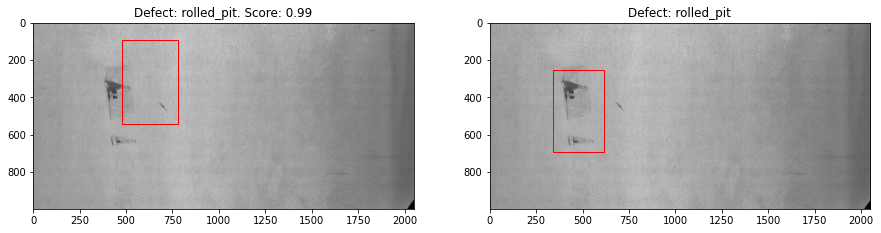

In [ ]:
from random import choice

for cl in test_df.defect_id.unique():
  rand_example = choice(test_df_2[test_df_2.defect_id==cl].index)
  prediction_show(rand_example)

Видим, что рамки часто очень далеки от реального расположения рамок. Построим распределения значений xmin, xmax, ymin, ymax для оценки разброса реальных и предсказанных значений.

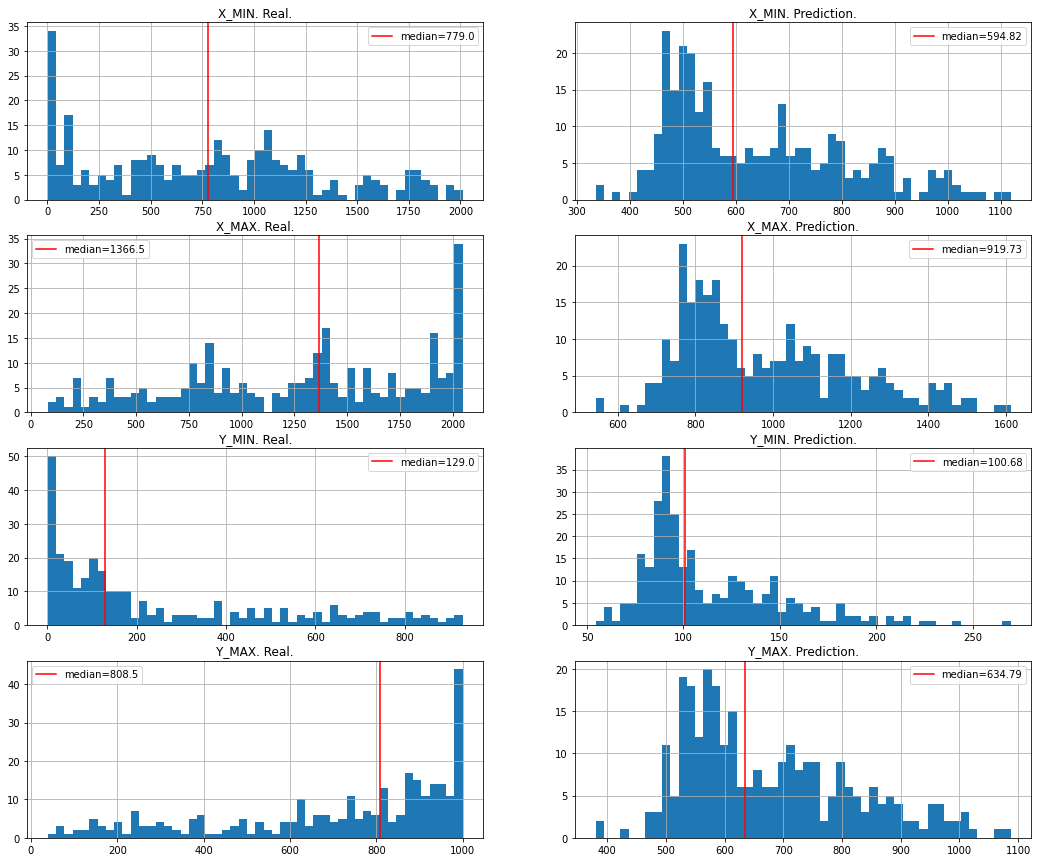

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(18, 15))

########################################## x_min ################################################
axs[0,0].set_title('X_MIN. Real.') 
axs[0,0].hist(test_df['xmin'], bins=50)
axs[0,0].axvline(x=np.median(test_df['xmin']), color='red', label=f"median={np.round(np.median(test_df['xmin']),2)}")
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].set_title('X_MIN. Prediction.') 
axs[0,1].hist(np.array(pred_list)[..., 2], bins=50)
axs[0,1].axvline(x=np.median(np.array(pred_list)[..., 2]), color='red', label=f"median={np.round(np.median(np.array(pred_list)[..., 2]),2)}")
axs[0,1].grid()
axs[0,1].legend()

########################################## x_max ################################################
axs[1,0].set_title('X_MAX. Real.') 
axs[1,0].hist(test_df['xmax'], bins=50)
axs[1,0].axvline(x=np.median(test_df['xmax']), color='red', label=f"median={np.round(np.median(test_df['xmax']),2)}")
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].set_title('X_MAX. Prediction.') 
axs[1,1].hist(np.array(pred_list)[..., 3], bins=50)
axs[1,1].axvline(x=np.median(np.array(pred_list)[..., 3]), color='red', label=f"median={np.round(np.median(np.array(pred_list)[..., 3]),2)}")
axs[1,1].grid()
axs[1,1].legend()

########################################## y_min ################################################
axs[2,0].set_title('Y_MIN. Real.') 
axs[2,0].hist(test_df['ymin'], bins=50)
axs[2,0].axvline(x=np.median(test_df['ymin']), color='red', label=f"median={np.round(np.median(test_df['ymin']),2)}")
axs[2,0].grid()
axs[2,0].legend()

axs[2,1].set_title('Y_MIN. Prediction.') 
axs[2,1].hist(np.array(pred_list)[..., 4], bins=50)
axs[2,1].axvline(x=np.median(np.array(pred_list)[..., 4]), color='red', label=f"median={np.round(np.median(np.array(pred_list)[..., 4]),2)}")
axs[2,1].grid()
axs[2,1].legend()

########################################## y_max ################################################
axs[3,0].set_title('Y_MAX. Real.') 
axs[3,0].hist(test_df['ymax'], bins=50)
axs[3,0].axvline(x=np.median(test_df['ymax']), color='red', label=f"median={np.round(np.median(test_df['ymax']),2)}")
axs[3,0].grid()
axs[3,0].legend()

axs[3,1].set_title('Y_MAX. Prediction.') 
axs[3,1].hist(np.array(pred_list)[..., 5], bins=50)
axs[3,1].axvline(x=np.median(np.array(pred_list)[..., 5]), color='red', label=f"median={np.round(np.median(np.array(pred_list)[..., 5]),2)}")
axs[3,1].grid()
axs[3,1].legend();

Видим, что реальные распределения значений xmin, xmax, ymin, ymax имеют в основном более "широкий" разброс (крайние значения) по сравнению с предсказанными и сильно отличные медианные значения. Это говорит об очень низком качестве предсказания bounding boxes.

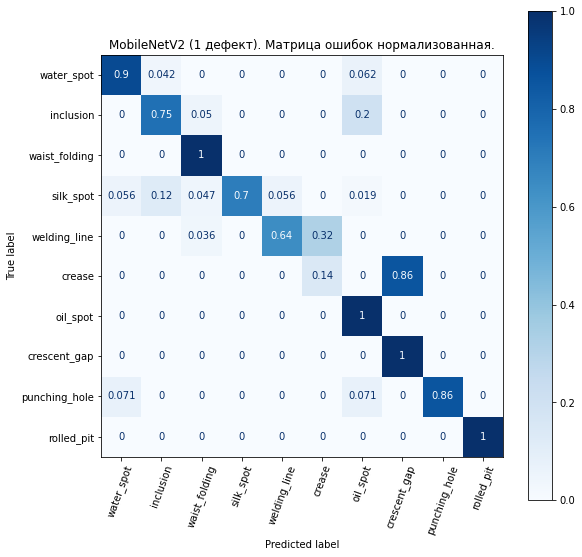

In [ ]:
cm = confusion_matrix(y_test[:len(test_pred)], test_pred.argmax(axis=1), normalize='true')   #последние записи удалены из-за пакетной обработки 
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_title("MobileNetV2 (1 дефект). Матрица ошибок нормализованная.", size=12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CFG.class_dict.keys())   
disp.plot(ax=ax, cmap = 'Blues')
plt.xticks(rotation=70)
plt.show()

При этом видно, что качество предсказания классов дефектов высокое (за исключением класса 'crease'). 

# 4. YOLOv3. Один дефект на изображении.

## 4.1. Глобальные параметры


In [ ]:
name_classes = list(df['defect_class'].unique()) # Названия классов 
num_classes = len(name_classes) # Количество классов
input_shape = (416, 416) # Размерность входного изображения для модели YOLO

# Массив используемых анкоров (в пикселях). Используетя по 3 анкора на каждый из 3 уровней сеток
# данные значения коррелируются с размерностью входного изображения input_shape
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]) 
num_anchors = len(anchors) # Сохраняем количество анкоров

print(num_classes)

10


## 4.2. Создание модели

### Функции

In [ ]:
'''
    Функция создания полной модели
        Входные параметры:       
          input_shape - размерность входного изображения для модели YOLO
          num_anchors - общее количество анкоров   
          use_weights - использовать ли предобученные веса         
          weights_path - путь к сохраненным весам модели  
'''
def create_model(
        input_shape,
        num_anchors,
        use_weights = False, 
        weights_path = 'yolo.h5'        
        ):
    w, h = input_shape # Получаем ширину и высоту входного изображения
    inputs = Input(shape = (w, h, 3)) # Создаем входной слой модели, добавляя размерность для глубины цвета
    
    # Создаем три входных слоя y_true с размерностями ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6) и (None, 52, 52, 3, 6))
    # 2 и 3 параметры (13, 13) указывают размерность сетки, на которую условно будет разбито исходное изображение
    # каждый уровень сетки отвечает за обнаружение объектов различных размеров (13 - крупных, 26 - средних, 52 - мелких)
    # 4 параметр - количество анкоров на каждый уровень сетки
    # 5 параметр - 4 параметра описывающие параметры анкора (координаты центра, ширина и высота) + вероятность обнаружения объекта + OHE номер класса
    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, num_classes + 5))] # Уровень сетки 13х13 (416/32)
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, num_classes + 5))) # Уровень сетки 26х26 (416/26)
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, num_classes + 5))) # Уровень сетки 52х52 (416/8)
    
    model_yolo = create_YOLOv3(inputs, num_anchors // 3) # Создаем модель YOLOv3
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes)) # Выводим сообщение о создании модели
    
    # Если установлен флаг загрузки весов
    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False) # Загружаем предобученные веса
        print ('Загружены веса из файла {}.'.format(weights_path)) # Выводим сообщение о загруженных весах
        
    # Создаем выходной слой Lambda (выходом которого будет значение ошибки модели)
    # На вход слоя подается:
    #   - model_yolo.output (выход модели model_yolo (то есть то, что посчитала сеть))
    #   - y_true (оригинальные данные из обучающей выборки)
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    return Model([inputs, *y_true], outputs) # Возвращаем модель

In [ ]:
'''
Функция создания модели YOLOv3
    Входные параметры:
          inputs - Входной слой модели
          num_sub_anchors - количество анкоров в каждом уровне сеток
'''
def create_YOLOv3(
        inputs,
        num_sub_anchors
        ):
    #--------------------
    # Базовая часть модели YOLOv3
    #--------------------
    
    # Состоит из Conv2D-слоев и Residual-блоков. Residual-блок - это блок использующий информацию из предыдущих слоев.
    # С помощью слоя Add (Суммируется текущий слой и один из предыдущих), что позволяет избежать проблему потери информации
    # Количество resedual блоков и архитектура сети взята из документации YOLOv3
    x = ConvBL (inputs, 32, (3, 3)) # Добавляем каскад из трех слоев (Conv2D, BatchNormalization и Leaky)
    x = resblock (x, 64, 1) # Добавляем 1 resedual-блок с 64 нейронами
    x = resblock (x, 128, 2) # Добавляем 2 resedual-блока с 128 нейронами
    x = resblock (x, 256, 8) # Добавляем 8 resedual-блоков с 256 нейронами
    x = resblock (x, 512, 8) # Добавляем 8 resedual-блоков с 512 нейронами
    x = resblock (x, 1024, 4) # Добавляем 4 resedual-блоков с 1024 нейронами
    base_model = Model(inputs, x) # Создаем базовую часть модели YOLOv3
    
    #--------------------
    # Detection часть модели YOLOv3
    #--------------------
    
    # Выделяем три выхода сети, соответсвующих различным уровням сетки
    
    
    # 13 x 13 (обнаружение больших объектов)
    x = ConvBL(base_model.output, 512, (1, 1))    
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    
    # Выделяем первый выход модели, соответствующий размерности 13 х 13
    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)
    
    
    # 26x26 (обнаружение средних объектов)
    
    # Размерность текущего выхода сети равна 13 х 13. Необходимо увеличить ее до 26 x 26 и
    # объеденить со 152-ым слоем (размерностью 26 x 26)
    x = ConvBL(x, 256, ( 1, 1)) 
    x = UpSampling2D(2) (x) # Увеличиваем размерность до 26 на 26, использую UpSampling
    x = Concatenate()([x,base_model.layers[152].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 256, (1, 1))  
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    
    # Выделяем второй выход модели, соответствующий размерности 26 х 26
    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)
    
    # 52 x 52 (обнаружение маленьких объектов)
    
    # Размерность текущего выхода сети равна 26 х 26. Необходимо увеличить ее до 52 x 52 и
    # объеденить со 92-ым слоем (размерностью 52 x 52)
    x = ConvBL(x, 128, ( 1, 1)) 
    x = UpSampling2D(2) (x)  # Увеличиваем размерность до 52 на 52, использую UpSampling
    x = Concatenate()([x,base_model.layers[92].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 128, (1, 1))  
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    
    # Выделяем третий выход модели, соответствующий размерности 52 х 52
    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)
    
    return Model(inputs, [y1, y2, y3]) # Возвращаем модель

In [ ]:
''' Функция создания Residual блока.
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          num_filters - количество нейронов
          num_blocks  - количество блоков 
 '''
def resblock(
        inputs,
        num_filters,
        num_blocks
        ):
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs) # Увеличиваем размерность на один шаг влево и вверх
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2)) # Добавляем блок ConvBL
    for i in range(num_blocks): # Пробегаем в цикле num_blocks-раз (суммируя слои с помощью Add())
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x # Возвращаем слой

In [ ]:
''' Функция создания блока Conv2D, BatchNormalization, LeakyRelu
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          args - массив неименованных параметров
          kwargs  - массив именованных параметров
 '''
def ConvBL(
        inputs,
        *args,
        **kwargs
        ): 
    new_kwargs = {'use_bias': False} # создаем новый массив именованных параметров, добавляя параметр use_bias
    new_kwargs['kernel_regularizer'] = l2(5e-4) # добавляем параметр kernel_regularizerpadding
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' # добавляем параметр  padding
    new_kwargs.update(kwargs) # Добавляем уже имеющиеся в kwargs gfhfvtnhs
    x = Conv2D(*args, **new_kwargs) (inputs) # Добавляем Conv2D слой
    x = BatchNormalization() (x) # Добавляем слой BatchNormalization
    x = LeakyReLU(alpha=0.1) (x) # Добавляем слой LeakyRelu
    return x

In [ ]:
'''
Функция подсчета ошибки.
    Входные параметры:
        inputs - Входные данные
        num_anchors - общее количество анкоров                    
'''
def yolo_loss(
      inputs,
      num_anchors
      ):
    ignore_thresh = .5 # Порог вероятности обнаружения объекта
    num_layers = num_anchors // 3 # Подсчитываем количество анкоров на каждом уровне сетки
    y_pred = inputs[:num_layers] # Из входных данных выцепляем посчитанные моделью значения
    y_true = inputs[num_layers:] # Из входных данных выцепляем эталонные значения
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] # Задаем маску анкоров для каждого уровня сеток
    # ([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]])
   
    
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Считываем количество элементов
    m = K.shape(y_pred[0])[0] # Размер пакета
    batch_size = K.cast(m, K.dtype(y_pred[0])) # Преобразуем к типу y_pred[0]
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров). 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровян сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        # Считаем ошибку в определении координат центра объекта
        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # Считаем ошибку в определении координат ширины и высоты
        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        def loop_body(
                b,
                ignore_mask
                ):
            # в true_box запишутся первыые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            return b+1, ignore_mask # Увеличиваем счетчик на еденицу и возвращаем ignore_mask
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонентя - для значений, которые были верно спредиктены
        # 2 компонентя - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки   

In [ ]:
'''
    Функция подсчета IoU
'''
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2) # Добавляем одну размерность
    xy1 = input1[..., :2] # Получаем координаты x,y центра 
    wh1 = input1[..., 2:4] # Получаем значения высоты и ширины
    wh_half1 = wh1 / 2. # Делим значения высоты и ширины пополам
    top_left1 = xy1 - wh_half1 # Получаем значение, соответствующее верхнему левому углу
    right_bottom1 = xy1 + wh_half1 # Получаем значение, соотвествующее правому нижнему углу
    
    input2 = K.expand_dims(input2, 0) # Добавляем одну размерность
    xy2 = input2[..., :2] # Получаем координаты x,y центра 
    wh2 = input2[..., 2:4] # Получаем значения высоты и ширины
    wh_half2 = wh2 / 2. # Делим значения высоты и ширины пополам
    top_left2 = xy2 - wh_half2 # Получаем значение, соответствующее верхнему левому углу
    right_bottom2 = xy2 + wh_half2 # Получаем значение, соотвествующее правому нижнему углу
    
    intersect_mins = K.maximum(top_left1, top_left2) # Берем максимальные координаты из левых верхних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) # Берем Минимальные координаты координаты из правых нижних углов
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # Считаем ширину и высоту области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # Считаем площадь области пересечения
    
    area1 = wh1[..., 0] * wh1[..., 1] # Считаем площадь первых элементов
    area2 = wh2[..., 0] * wh2[..., 1] # Считаем площадь вторых элементов
    
    return intersect_area / (area1 + area2 - intersect_area) # Возвращаем IoU
    

### Основной код

In [ ]:
# Создаем модель

model_YOLO = create_model(input_shape, num_anchors)

Создана модель YOLOv3. Количество классов: 10.


In [ ]:
# Выводим входные размерности для модели
model_YOLO.input

[<KerasTensor: shape=(None, 416, 416, 3) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, 13, 13, 3, 15) dtype=float32 (created by layer 'input_6')>,
 <KerasTensor: shape=(None, 26, 26, 3, 15) dtype=float32 (created by layer 'input_7')>,
 <KerasTensor: shape=(None, 52, 52, 3, 15) dtype=float32 (created by layer 'input_8')>]

In [ ]:
# Выводим выходную размерность модели
model_YOLO.output

<KerasTensor: shape=() dtype=float32 (created by layer 'yolo_loss')>

In [ ]:
# Выводим информацию о модели
model_YOLO.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 416, 416, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 416, 416, 32  128        ['conv2d[0][0]']                 
 ormalization)                  )                                                           

## 4.3. Обучение модели

### Демонстрация подготовки данных для обучения

На вход модели подается 2 параметра:
       1. numpy-массив размерностью (416,416,3), соответствующий исходному изображению
       2. трехмерный массив y_true, в котором записана информация об анкоре, описывающем наш объект
             размерность первого элемента массива (13,13,3,6) -  13на13 - размер сетки, 
                                                                  3 - количество анкоров для каждой ячейки сетки,
                                                                  6 - параметры анкора
             размерность второго элемента массива (26,26,3,6)
             размерность третьего элемента массива (52,52,3,6)

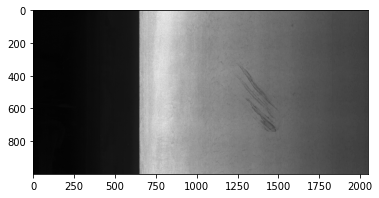

In [ ]:
# Открываем файл сегментированной модели
filename = 'img_01_424995500_00255' # Имя файла   
image = Image.open(image_dir+f'{name_classes[0]}/'+filename+'.jpg') # Загружаем изображение   
img1 = ImageDraw.Draw(image) # Создаем экземпляр изображения
plt.imshow(image, cmap='gray') # Рисуем изображение

In [ ]:
# Запишем всю информацию об объекте в словарь
dictionary = {} # Создаем словарь
class_id = 0 # Номер класса. У нас всего один класс
key = filename # Значение ключа соответсвует имени модели
dictionary[key] = f'{name_classes[0]}/'+key+'.jpg'+' '+str(df[df.file_id==filename].xmin.values[0])+','+\
                                                       str(df[df.file_id==filename].ymin.values[0])+','+\
                                                       str(df[df.file_id==filename].xmax.values[0])+','+\
                                                       str(df[df.file_id==filename].ymax.values[0])+','+\
                                                       str(df[df.file_id==filename].defect_id.values[0]) # Записываем
      # информацию об изображении: Имя_файла minX,minY,maxX,maxY,class_id
print (dictionary) # Выводим словарь

{'img_01_424995500_00255': 'water_spot/img_01_424995500_00255.jpg 1169,317,1577,809,0'}


Размер исходного изображения:  2048 1000
Размерность входных данных для модели: 416 416
Параметры ограничивающей рамки [[1169  317 1577  809    0]]


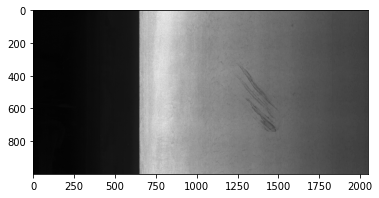

In [ ]:
# Загружаем оригинальное изображение
line = dictionary[filename].split() # Сплитим по пробелу значение в словаре
image = Image.open(image_dir+line[0]) # Загружаем файл изображения
iw, ih = image.size # Запоминаем оригинальные размеры изображения
w, h = (416,416) # Устанавливаем ширину и высоту изображения для модели YOLO
box = np.array([np.array(list(map(lambda x: int((float)(x)), box.split(',')))) for box in line[1:]]) # Получаем список параметров для ограничивающих рамом для всех объектов
                                                                                                     # на изображении. В нашем случае будет всего одна ограничивающая рамка
plt.imshow(image, cmap='gray')   # рисуем изображение        
print ('Размер исходного изображения: ',iw, ih) # Выводим размер исходного изображения
print ('Размерность входных данных для модели:', h, w) # Выводим размеры изображения для входного слоя модели YOLO
print ('Параметры ограничивающей рамки', box) # Выводим параметры ограничивающей рамки

Коэффициент масштабирования:  1.747531812704997
Новый размер изображения:  712 726


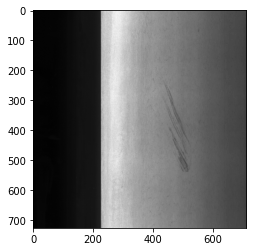

In [ ]:
# Аугментация изображения

# Функция получения случайного числа
def rand(a = 0, b = 1):
  return np.random.rand() * (b - a) + a

# -----
# Параметры для аугментации изображения
# -----
jitter = .3
hue = .1
sat = 1.5
val = 1.5

# Масштабируем изображение
new_ar = w / h * rand(1 - jitter, 1 + jitter) / rand(1 - jitter, 1 + jitter)
scale = rand(.65, 2) 
print ('Коэффициент масштабирования: ', scale)
# Масштабируем изображение
if new_ar < 1:
    nh = int(scale * h)
    nw = int(nh * new_ar)
else:
    nw = int(scale * w)
    nh = int(nw / new_ar)
print ('Новый размер изображения: ',nw, nh)
image1 = image.resize((nw,nh), Image.BICUBIC) # Изменяем размер исходного изображения
plt.imshow(image1, cmap='gray') # Рисуем изображение

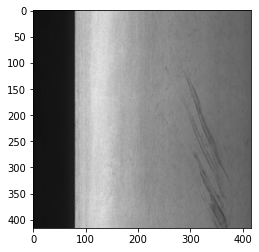

In [ ]:
# Приводим к размеру 416 на 416 пикселей для модели YOLO и размещаем в случайном месте на изображении
dx = int(rand(0, w - nw)*0.5)
dy = int(rand(0, h - nh)*0.5)
new_image = Image.new('RGB', (w, h), (128,128,128))
new_image.paste(image1, (dx, dy))
image2 = new_image
plt.imshow(image2, cmap='gray')

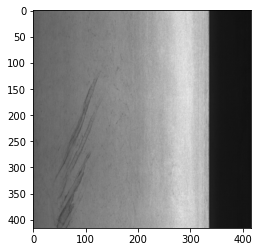

In [ ]:
# Случаным образом отображаем изображение по горизонтали
flip = rand() < .5 # с вероятностью 50% получаем параметр отражения картинки
if flip: 
    image2 = image2.transpose(Image.FLIP_LEFT_RIGHT) # Если требуется, то отражаем картику по горизонтале
plt.imshow(image2, cmap='gray') # Рисуем картинку

(416, 416, 3)


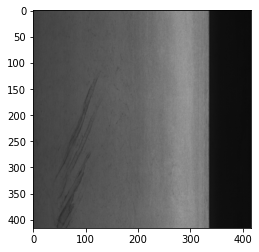

In [ ]:
# Случайным образом меняем освещенность, экспозицию, гамму изображения
hue1 = rand(-hue, hue)
sat1 = rand(1, sat) if rand() < .5 else 1 / rand(1, sat)
val1 = rand(1, val) if rand() < .5 else 1 / rand(1, val)
x = rgb_to_hsv(np.array(image2) / 255.)                    # Hue, Saturation, Value — тон, насыщенность, значение
x[..., 0] += hue1
x[..., 0][x[..., 0] > 1] -= 1
x[..., 0][x[..., 0] < 0] += 1
x[..., 1] *= sat1
x[..., 2] *= val1
x[x > 1] = 1
x[x < 0] = 0
image_data = hsv_to_rgb(x) # numpy array, 0 to 1
print (image_data.shape) # Входные данные для модели YOLO, соответствующие изображению, размерностью 416х416х3
plt.imshow(image_data, cmap='gray') # Рисуем изображение

[ 14. 111. 156. 416.   0.]


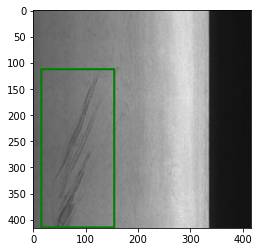

In [ ]:
# Корректируем параметры ограничивающей рамки
max_boxes = 5 # Устанавливаем максимальное кличество ограничивающих рамок
box_data = np.zeros((max_boxes,5)) # Массив будет хранить параметры ограничивающих рамок. Всего 5 параметров. Первые 4 - координаты minX, minY, maxX, maxY. 5-ый - номер класса объекта (в нашем случае всего один класс - самолеты)

box_mod = box.copy()
# Проходим те же модификации с ограничивающей рамкой, что и с изображением: масштабирование, отражение
box_mod[:, [0,2]] = box_mod[:, [0,2]] * nw / iw + dx     # nw - новая ширина, iw - исходня ширина изображения, dx - смещение по x 
box_mod[:, [1,3]] = box_mod[:, [1,3]] * nh / ih + dy

if flip: 
    box_mod[:, [0,2]] = w - box_mod[:, [2,0]]            # w - ширина изображения для подачи в сеть

box_mod[:, 0:2][box_mod[:, 0:2] < 0] = 0
box_mod[:, 2][box_mod[:, 2] > w] = w # Если выходит за ширину
box_mod[:, 3][box_mod[:, 3] > h] = h # Если выходит за высоту
box_w = box_mod[:, 2] - box_mod[:, 0] 
box_h = box_mod[:, 3] - box_mod[:, 1]
box_mod = box_mod[np.logical_and(box_w > 1, box_h > 1)] # Отсекаем маленькие рамки

if len(box_mod) > max_boxes: 
    box_mod = box_mod[:max_boxes] # Если количество ограничивающих рамок больше установленного нами ранее
box_data[:len(box_mod)] = box_mod # Записываем в box_data информацию об ограничивающих рамках аугментированного изображения
print(box_data[0]) # Выводим параметры рамки для аугментированного изображения
img1 = ImageDraw.Draw(image2) # Создаем экземпляр изображения
for i in range(4): # Рисуем ограничивающую рамку
    img1.rectangle([box_data[0][0] + i, box_data[0][1] + i, box_data[0][2] - i, box_data[0][3] - i], outline = 'green')
plt.imshow(image2, cmap='gray')

In [ ]:
# box_data - minX, minY, maxX, maxY
num_layers = 3 # Количество анкоров на каждую сетку (в нашем случае каждая сетка будет иметь анкоры 3 разных размеров)
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Маска для выбора анкоров
   
real_boxes = np.array(box_data, dtype='float32') # Переводим в numpy
input_shape = np.array((416,416), dtype='int32') # Переводим в numpy

# Определяем центр ограничивающей рамки и ее ширину и высоту
boxes_xy = (real_boxes[:,0:2] + real_boxes[:,2:4]) // 2
boxes_wh = real_boxes[..., 2:4] - real_boxes[..., 0:2]

print('Центр ограничивающей рамки: ', boxes_xy[0])
print('Ширина и высота ограничивающей рамки:', boxes_wh[0])

Центр ограничивающей рамки:  [ 85. 263.]
Ширина и высота ограничивающей рамки: [142. 305.]


In [ ]:
# Переводим параметры ограничивающей рамки в относительные координаты (от 0 до 1)
real_boxes[:, 0:2] = boxes_xy/input_shape[0]
real_boxes[:, 2:4] = boxes_wh/input_shape[1]
print(real_boxes[0])  # Первые два элемента - центр ограничивабщей рамки в относительных координатах, 
                      # Вторые два элемента - ширина и высота ограничивающей рамки в относительных размерах
                      # Пятый элемент - класс объекта

[0.20432693 0.63221157 0.34134614 0.7331731  0.        ]


In [ ]:
# Создадим заготовку под входные слои y_true
cells = [13,26,52]
y_true = [np.zeros((cells[l],cells[l],len(anchor_mask[l]),5+num_classes),dtype='float32') for l in range(num_layers)]
print(y_true[0].shape)
print(y_true[1].shape)
print(y_true[2].shape)
# Таким образом получаем массив из трех сеток разных размеров (13х13, 26х26, 52х52), где каждая ячейка содержит
# три варинта пар анкоров и 5+1 параметр описания каждой из пар анкоров

(13, 13, 3, 15)
(26, 26, 3, 15)
(52, 52, 3, 15)


In [ ]:
# из 9 анкоров фиксированного размера требуется найти тот, который максимально охватывает ограничивающую рамку
# для этого пробегаем по всем имеющимся анкорам и считаем IoU всех вариантов

# Площадь, занятая ограничивающей рамкой
wh = boxes_wh[0, :] # Получаем ширину и высоту
box_area = wh[0] * wh[1] # Считаем площадь рамки
print (wh[0],'*',wh[1],'=', box_area)

142.0 * 305.0 = 43310.0


In [ ]:
# Площади, которые занимают анкоры
anchor_area = anchors[:, 0] * anchors[:, 1]
print (anchor_area)

[   130    480    759   1830   2790   7021  10440  30888 121598]


In [ ]:
# Получим новые параметры анкоров, значения которых не превышают значения высоты и ширины ограничивающей рамки
correct_anchors = []
for elem in anchors:
    correct_anchors.append ([min(elem[0], wh[0]), min(elem[1], wh[1])])
correct_anchors = np.array(correct_anchors)
print(correct_anchors)
# Площади, которые занимаю скорректированные анкоры
correct_anchors_area = correct_anchors[:,0] * correct_anchors[:,1]
print(correct_anchors_area)

[[ 10.  13.]
 [ 16.  30.]
 [ 33.  23.]
 [ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]
 [116.  90.]
 [142. 198.]
 [142. 305.]]
[  130.   480.   759.  1830.  2790.  7021. 10440. 28116. 43310.]


In [ ]:
# Подсчитвываем iou всех вариантов
iou = correct_anchors_area / (box_area + anchor_area - correct_anchors_area)
print(iou)

[0.00300162 0.01108289 0.01752482 0.04225352 0.0644193  0.16211037
 0.24105287 0.61012977 0.35617362]


In [ ]:
# Определяем позицию лучшего анкора
best_anchor = np.argmax(iou, axis=-1)
print (best_anchor)

7


In [ ]:
print('Параметры ограничивающей рамки',real_boxes[0])
for l in range(num_layers): # Пробегаем по всем 3 уровням анкорв
    if best_anchor in anchor_mask[l]: # Если лучший анкор есть в l-ом элементе маски анкоров
        print('Уровень анкора =',l)
        i = np.floor(real_boxes[0,0]*cells[l]).astype('int32') # Определяем позицию ячейки по горизонтале
        print ('i =',i)    
        j = np.floor(real_boxes[0,1]*cells[l]).astype('int32') # Определяем позицию ячейки по вертикале
        print ('j =',j)    
        k = anchor_mask[l].index(best_anchor) # Определяем номер анкора в маске анкоров
        print('Номер поданкора =',k)    
        c = real_boxes[0, 4].astype('int32') # Записываем номер класса объекта
        print ('Номер класса =',c)    
        y_true[l][j, i, k, 0:4] = real_boxes[0, 0:4] # Записываем 4 параметра объекта - координаты центра, ширина и высота
        y_true[l][j, i, k, 4] = 1 # Записываем вероятность того, что найден объект (для обучающей выборки всегда 1)
        y_true[l][j, i, k, 5+c] = 1  # В позицию 5+с записываем класс объекта (ohe)
        break

print(y_true[l][j,i,...])
# Таким образом массив y_true состоит полностью из 0 и только в 0-ом элементе, который соответсвует сетке, разбиением 13 на 13,
# в ячейке (6,6), которая соответствует позиции центра ограничивающей рамки (0.5, 0.4903846) в позиции 1 анкора, 
# максимально охватывающего наш объект будет записана вся необходимая информация 
# [0.5       0.4903846 1.        0.46875   1.        1.       ]
# первые 4 элемента - координаты центр объекта, ширина и высота, 5ый элемент - вероятность объекта (1),
# 6ой-элемент - единица в позиции класса объекта

Параметры ограничивающей рамки [0.20432693 0.63221157 0.34134614 0.7331731  0.        ]
Уровень анкора = 0
i = 2
j = 8
Номер поданкора = 1
Номер класса = 0
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.20432693 0.63221157 0.34134614 0.7331731  1.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]


### Функции


In [ ]:
# Функция генерации данных
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    n = len(annotation_lines) # Получаем количество элементов в словаре аннотаций
    i = 0 # Задаем начальный индекс
    while True:
        image_data = [] # Массив для хранения изображений 416х416
        box_data = [] # Массив для хранения bounding_box данных
        for b in range(batch_size): # Пробегаем по всему batch_size
            if i==0: # Если первая итерация цикла
                np.random.shuffle(annotation_lines) # Перемешиваем элементы
            image, box = augmentation(annotation_lines[i]) # Делаем аугментацию картинок и ограничивающих рамок
            image_data.append(image) # Добавляем полученную картинку в результирующий массив 
            box_data.append(box) # Добавляем полученную ограничивающую рамку в массив bounding_box
            i = (i+1) % n # Обновляем значение индека (не превышая общего количества элементов)
        image_data = np.array(image_data) # Преобразуем в numpy
        box_data = np.array(box_data) # Преобразуем в numpy
        y_true = get_y(box_data, anchors, input_shape) # По значению ограничивающей рамки получаем y_true        
        yield [image_data, *y_true], np.zeros(batch_size) # Возвращаем порцию данных для обучения

In [ ]:
# Случайная аугментация изображения
def augmentation(data):
    # Словарь с параметрами аугментации
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    
    data = data.split() # Сплитим входную строку словаря
    image = Image.open(image_dir + data[0]) # Открываем изображение самолета
    width_i, height_i = image.size # Получаем ширину и высоту оригинального изображения
    widht_shape, height_shape = input_shape[:2] # Получаем ширину и высоту входного изображения для модели RetinaNet
    
    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw)*0.5)
    dy = int(rand(0, height_shape - nh)*0.5)
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    # С вероятностью 50% отображаем по горизонтале
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив
    
    max_boxes = 4 # Устанавливаем максимальное количество рамок на изображении
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5) 
    if len(box)>0:                
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        # Отражаем по горизонтале
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        # Считаем высоту и ширину рамок и оставляем только те, значения которых больше 1
        box_w = box[:, 2] - box[:, 0] # xRight - xLeft
        box_h = box[:, 3] - box[:, 1] # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes: # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box # Записываем данные в box_data
    
    # Возвращаем изменные изображение и ограничивающую рамку
    return image_data, box_data # Возвращаем аугментированные изображение и bounding_box

In [ ]:
# Функция подсчета y
def get_y(true_boxes, anchors, input_shape):
    num_layers = len(anchors) // 3 # Получаем количество анкоров для каждого уровня сеток
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маску анкоров для каждого уровня

    true_boxes = np.array(true_boxes, dtype='float32') # Преобразуем bounding_box в numpy
    input_shape = np.array(input_shape, dtype='int32') # Преобразуем input_shape в numpy
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] # Получаем ширину и высоту bounding_box (xRight - xLeft)
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] # Получаем высоту и ширину bounding_box В относительных значениях

    m = true_boxes.shape[0] # Получаем количество элементов в batch_size
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])

    # Создаем 0-вые списки для y_true
    # y_true[0].shape = (None, 13, 13, 3, 6)
    # y_true[1].shape = (None, 26, 26, 3, 6)
    # y_true[2].shape = (None, 52, 52, 3, 6)
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
              dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0) # Добавляем размерность

    # Параметры для IoU
    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        wh = boxes_wh[b, valid_mask[b]] # Получаем ширину и высоту текущего bounding_box
        if len(wh)==0: continue # Выходим если она нулевая
        wh = np.expand_dims(wh, -2) # Добавляем размерность
        
        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) # Находим лучшее значение iou для всех анкоров 

        for t, n in enumerate(best_anchor): 
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    return y_true

In [ ]:
def get_dict(df):
  dictionary = {}
  for index, row in df.iterrows():
    key = row['file_id']
    dictionary[key] = row['defect_class'] + '/' + key + '.jpg' + ' '+   str(row['xmin'])+','+\
                                                                        str(row['ymin'])+','+\
                                                                        str(row['xmax'])+','+\
                                                                        str(row['ymax'])+','+\
                                                                        str(row['defect_id'])  # 0

  print ('Завершена обработка классов') # Выводим сообщение о завершении обработки
  return dictionary # Возвращаем словарь

In [ ]:
def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

### Балансировка классов через аугментацию

Для классов, где кол-во примеров ниже 140, увеличим кол-во примеров до 140 через аугментацию. Один раз создадим новые изображения и сохраним их и полученную разметку bounding boxes для дальнейшего обучения.

In [ ]:
defect_df = df.defect_class.value_counts().reset_index().rename(columns={'index': 'defect_name'})
defect_df

defect_name  defect_class
0      silk_spot           568
1     water_spot           243
2  waist_folding           142
3   welding_line           142
4      inclusion           104
5   crescent_gap            99
6       oil_spot            71
7  punching_hole            71
8         crease            35
9     rolled_pit            14

In [ ]:
def aug_class(cl_list, i):
  
  new_box = [0,0,0,0,0]
  while new_box == [0,0,0,0,0]:
    data = np.random.choice(cl_list)
    image_data, box_data = augmentation(data)
    new_box = list(box_data[0])

  image_filename = f'images_aug/image_{i}.jpg'
  image_path = image_dir+image_filename
  cv2.imwrite(image_path, image_data*255)
  

  s = ''
  for i in box_data[0]:
    s+= str(int(i))+',' 

  all_data = [image_filename + ' ' + s[:-1], data]

  return all_data

In [ ]:
# ПЕРЕЗАПУСКАТЬ НЕ НУЖНО! ДАННЫЕ СОЗДАНЫ ОДИН РАЗ И СОХРАНЕНЫ!

# %%time

# aug_data = []
# j=0

# for cl in defect_df.defect_name.unique():
#   if defect_df[defect_df.defect_name==cl].defect_class.values[0]<140:

#     cl_list = np.array(list(get_dict( df[df.defect_class==cl] ).values()))
#     for i in tqdm(range(0+j, (140-defect_df[defect_df.defect_name==cl].defect_class.values[0]) + j)):
#       aug_data.append(aug_class(cl_list, i))
#     j=i+1

# aug_data = np.array(aug_data)      

Завершена обработка классов


100%|██████████| 36/36 [00:30<00:00,  1.17it/s]


Завершена обработка классов


100%|██████████| 41/41 [00:32<00:00,  1.25it/s]


Завершена обработка классов


100%|██████████| 69/69 [00:52<00:00,  1.30it/s]


Завершена обработка классов


100%|██████████| 69/69 [00:58<00:00,  1.18it/s]


Завершена обработка классов


100%|██████████| 105/105 [00:58<00:00,  1.79it/s]


Завершена обработка классов


100%|██████████| 126/126 [00:57<00:00,  2.18it/s]

CPU times: user 56.9 s, sys: 1.42 s, total: 58.3 s
Wall time: 4min 51s


In [ ]:
# with open('drive/MyDrive/Project/data/label_aug/data_aug.pickle', 'wb') as f:
#   pickle.dump(aug_data, f)

In [ ]:
with open('drive/MyDrive/Project/data/label_aug/data_aug.pickle', 'rb') as f:
  aug_data = pickle.load(f)

In [ ]:
len(aug_data)

446

In [ ]:
aug_data[-1]

array(['images_aug/image_445.jpg 354,237,407,285,9',
       'rolled_pit/img_03_4402117400_00003.jpg 54,719,305,880,9'],
      dtype='<U61')

In [ ]:
img_zero = []

for img in aug_data:
  if img[0].split(' ')[1]=='0,0,0,0,0':
    img_zero.append(img)

len(img_zero)

0

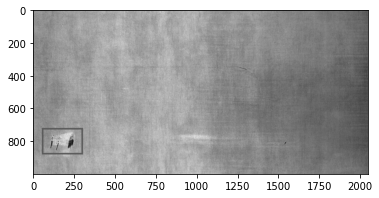

In [ ]:
# Открываем файл сегментированной модели
filename = 'img_03_4402117400_00003' # Имя файла   img_02_425616500_00770
image = Image.open(image_dir+'rolled_pit/'+filename+'.jpg') # Загружаем изображение     punching_hole
img1 = ImageDraw.Draw(image) # Создаем экземпляр изображения

for i in range(10): # Рисуем ограничивающую рамку
    img1.rectangle([54 + i, 719 + i, 305 - i, 880 - i], outline = 'red')
plt.imshow(image, cmap='gray');

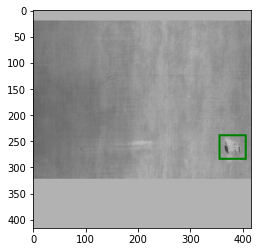

In [ ]:
image = Image.open(image_dir+'images_aug/'+'image_445.jpg') # Загружаем изображение 
img1 = ImageDraw.Draw(image) # Создаем экземпляр изображения

for i in range(4): # Рисуем ограничивающую рамку
    img1.rectangle([354 + i, 237 + i, 407 - i, 285 - i], outline = 'green')
plt.imshow(image);

### Подготовка данных

In [ ]:
dictionary = get_dict(df) # Вызываем функцию создания словаря  
dictionary_np = np.array(list(dictionary.values()))
len(dictionary_np)

Завершена обработка классов


1489

In [ ]:
aug_data_new = []
for el in aug_data:
  aug_data_new.append(str(el[0]))
aug_data_new[0]

'images_aug/image_0.jpg 0,137,26,229,1'

In [ ]:
dict_all = np.array(list(dictionary_np) + aug_data_new)
len(dict_all)

1935

In [ ]:
dict_cl = defaultdict(list)
for el in dict_all:
  cl = el[-1]
  dict_cl[cl].append(el)

In [ ]:
dict_cl.keys()

dict_keys(['0', '1', '2', '4', '5', '7', '6', '8', '3', '9'])

In [ ]:
# ПЕРЕЗАПУСКАТЬ НЕ НУЖНО! ДАННЫЕ СОЗДАНЫ ОДИН РАЗ И СОХРАНЕНЫ!

# data_train = []
# data_val = []
# data_test = []

# cf_val = 0.2
# cf_test = 0.2

# for key in dict_cl.keys():

#   np.random.seed(CFG.seed)  
#   np.random.shuffle(dict_cl[key])
  
#   len_cl = len(dict_cl[key])

#   test_tmp = dict_cl[key][-int(np.floor(len_cl*cf_test)):]
#   val_tmp = dict_cl[key][:-int(np.floor(len_cl*cf_test))][-int(np.floor(len_cl*cf_val)):]
#   train_tmp = dict_cl[key][:-int((np.floor(len_cl*cf_test))+int(np.floor(len_cl*cf_val)))]

#   data_test.append(test_tmp)
#   data_val.append(val_tmp)
#   data_train.append(train_tmp)
 
# np.random.seed(None)

In [ ]:
def ext(data):
  data_new = []
  for i in data:
    data_new.extend(i)
  return data_new

In [ ]:
# data_train = ext(data_train)
# data_val = ext(data_val)
# data_test = ext(data_test)

# print(len(data_train))
# print(len(data_val))
# print(len(data_test))

1165
385
385


In [ ]:
# with open('drive/MyDrive/Project/data/label_aug/data_train.pickle', 'wb') as f:
#   pickle.dump(data_train, f)

# with open('drive/MyDrive/Project/data/label_aug/data_val.pickle', 'wb') as f:
#   pickle.dump(data_val, f)

# with open('drive/MyDrive/Project/data/label_aug/data_test.pickle', 'wb') as f:
#   pickle.dump(data_test, f)

In [ ]:
# for el in data_train:
#  if el.split(' ')[-1] == '0,0,0,0,0':
#    print(el)

In [ ]:
with open('drive/MyDrive/Project/data/label_aug/data_val.pickle', 'rb') as f:
  data_val = pickle.load(f)

with open('drive/MyDrive/Project/data/label_aug/data_test.pickle', 'rb') as f:
  data_test = pickle.load(f)

with open('drive/MyDrive/Project/data/label_aug/data_train.pickle', 'rb') as f:
  data_train = pickle.load(f)

print(len(data_train))
print(len(data_val))
print(len(data_test))

1165
385
385


### Обучение

#### LR 0.001. 100 эпох. SGD.

In [ ]:
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=SGD(learning_rate=lr_value), loss={'yolo_loss': lambda y_true, y_pred: y_pred})  # SGD

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr001_ep0_30.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 30,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'/loss_lr001_ep0_30.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr001_ep0_30.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-62-e864c50945c8>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 1/30
116/116 [==============================] - 203s 1s/step - loss: 92.1354 - val_loss: 53.1590
Epoch 2/30
116/116 [==============================] - 131s 1s/step - loss: 27.1945 - val_loss: 28.8355
Epoch 3/30
116/116 [==============================] - 129s 1s/step - loss: 26.4725 - val_loss: 26.6983
Epoch 4/30
116/116 [==============================] - 130s 1s/step - loss: 26.7598 - val_loss: 26.2196
Epoch 5/30
116/116 [==============================] - 130s 1s/step - loss: 25.6310 - val_loss: 25.2017
Epoch 6/30
116/116 [==============================] - 129s 1s/step - loss: 25.5106 - val_loss: 25.1038
Epoch 7/30
116/116 [==============================] - 130s 1s/step - loss: 24.9263 - val_loss: 24.8519
Epoch 8/30
116/116 [==============================] - 129s 1s/step - loss: 24.7103 - val_loss: 23.7805
Epoch 9/30
116/116 [==============================] - 129s 1s/step - loss: 24.1437 - val_loss: 23.9219
Epoch 10/30
116/116 [==============================] - 130s 1s/step - los

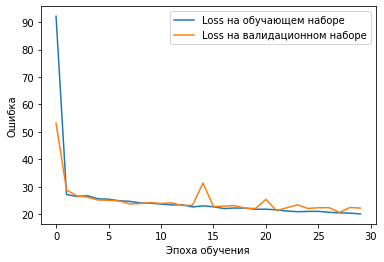

train_loss min: 20.133220672607425 , last train loss: 20.133220672607425
val_loss min: 20.68035888671875 , last val loss: 22.254898071289062


In [ ]:
# Первые 30 эпох
loss_train = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr001_ep0_30.csv')
values_train = loss_train.values[:, 1]

loss_val = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr001_ep0_30.csv')
values_val = loss_val.values[:, 1]

plt.plot(values_train, label='Loss на обучающем наборе')
plt.plot(values_val, label='Loss на валидационном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('train_loss min:', values_train.min(), ', last train loss:', values_train[-1])
print ('val_loss min:', values_val.min(), ', last val loss:', values_val[-1])

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr001_ep30_100.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 30
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr001_ep30_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr001_ep30_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-64-2416260beeea>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 31/100
116/116 [==============================] - 131s 1s/step - loss: 20.0640 - val_loss: 20.7544
Epoch 32/100
116/116 [==============================] - 128s 1s/step - loss: 20.1407 - val_loss: 22.9931
Epoch 33/100
116/116 [==============================] - 130s 1s/step - loss: 20.1651 - val_loss: 20.7816
Epoch 34/100
116/116 [==============================] - 129s 1s/step - loss: 19.9123 - val_loss: 21.6449
Epoch 35/100
116/116 [==============================] - 127s 1s/step - loss: 19.8986 - val_loss: 21.9397
Epoch 36/100
116/116 [==============================] - 129s 1s/step - loss: 19.9144 - val_loss: 22.4738
Epoch 37/100
116/116 [==============================] - 129s 1s/step - loss: 19.7511 - val_loss: 20.6365
Epoch 38/100
116/116 [==============================] - 128s 1s/step - loss: 19.7879 - val_loss: 20.2375
Epoch 39/100
116/116 [==============================] - 128s 1s/step - loss: 19.5165 - val_loss: 25.8001
Epoch 40/100
116/116 [==============================] -

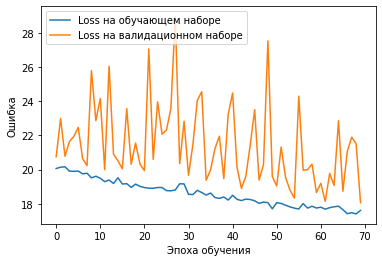

train_loss min: 17.40636444091797 , last train loss: 17.611494064331055
val_loss min: 18.0608024597168 , last val loss: 18.0608024597168


In [ ]:
# 30-100 эпох
loss_train = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr001_ep30_100.csv')
values_train = loss_train.values[:, 1]

loss_val = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr001_ep30_100.csv')
values_val = loss_val.values[:, 1]

plt.plot(values_train, label='Loss на обучающем наборе')
plt.plot(values_val, label='Loss на валидационном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('train_loss min:', values_train.min(), ', last train loss:', values_train[-1])
print ('val_loss min:', values_val.min(), ', last val loss:', values_val[-1])

#### LR 0.0001. 50 эпох. SGD.

In [ ]:
model_weight = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr001_ep30_100.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-4 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=SGD(learning_rate=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 10.
Загружены веса из файла drive/MyDrive/Project/weights_aug/weights_lr001_ep30_100.h5.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr0001_ep0_50.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 50,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr0001_ep0_50.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr0001_ep0_50.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-67-9677534f8fff>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 1/50
116/116 [==============================] - 437s 4s/step - loss: 17.1932 - val_loss: 17.9477
Epoch 2/50
116/116 [==============================] - 126s 1s/step - loss: 17.0884 - val_loss: 17.7256
Epoch 3/50
116/116 [==============================] - 124s 1s/step - loss: 17.1285 - val_loss: 17.7311
Epoch 4/50
116/116 [==============================] - 126s 1s/step - loss: 17.1514 - val_loss: 17.6345
Epoch 5/50
116/116 [==============================] - 127s 1s/step - loss: 17.0874 - val_loss: 17.5835
Epoch 6/50
116/116 [==============================] - 126s 1s/step - loss: 17.0657 - val_loss: 17.0349
Epoch 7/50
116/116 [==============================] - 125s 1s/step - loss: 16.9723 - val_loss: 17.6668
Epoch 8/50
116/116 [==============================] - 125s 1s/step - loss: 17.0392 - val_loss: 17.8246
Epoch 9/50
116/116 [==============================] - 125s 1s/step - loss: 17.0845 - val_loss: 17.3201
Epoch 10/50
116/116 [==============================] - 125s 1s/step - los

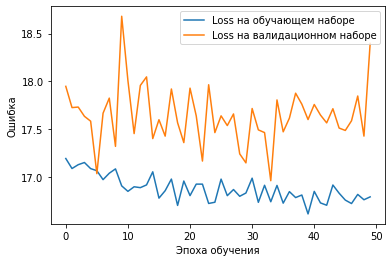

train_loss min: 16.61378288269043 , last train loss: 16.79205894470215
val_loss min: 16.96099853515625 , last val loss: 18.396841049194336


In [ ]:
# lr=0.0001  50 эпох
loss_train = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr0001_ep0_50.csv')
values_train = loss_train.values[:, 1]

loss_val = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr0001_ep0_50.csv')
values_val = loss_val.values[:, 1]

plt.plot(values_train, label='Loss на обучающем наборе')
plt.plot(values_val, label='Loss на валидационном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('train_loss min:', values_train.min(), ', last train loss:', values_train[-1])
print ('val_loss min:', values_val.min(), ', last val loss:', values_val[-1])

#### LR 0.00001. 250 эпох. Adam.

In [ ]:
# снижаем шаг обучения и меняем оптимизатор на Adam

lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(learning_rate=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep50_60.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 60,
                    verbose = 1,
                    initial_epoch = 50
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep50_60.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep50_60.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-70-3c79fb9c4fa7>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 51/60
116/116 [==============================] - 142s 1s/step - loss: 17.3013 - val_loss: 17.6386
Epoch 52/60
116/116 [==============================] - 128s 1s/step - loss: 17.0789 - val_loss: 17.5784
Epoch 53/60
116/116 [==============================] - 127s 1s/step - loss: 17.0869 - val_loss: 18.0979
Epoch 54/60
116/116 [==============================] - 125s 1s/step - loss: 17.2625 - val_loss: 17.6436
Epoch 55/60
116/116 [==============================] - 125s 1s/step - loss: 17.4705 - val_loss: 17.4474
Epoch 56/60
116/116 [==============================] - 125s 1s/step - loss: 17.0881 - val_loss: 17.7325
Epoch 57/60
116/116 [==============================] - 125s 1s/step - loss: 17.2900 - val_loss: 17.4471
Epoch 58/60
116/116 [==============================] - 125s 1s/step - loss: 17.1060 - val_loss: 17.7414
Epoch 59/60
116/116 [==============================] - 125s 1s/step - loss: 17.2227 - val_loss: 17.5765
Epoch 60/60
116/116 [==============================] - 125s 1s/s

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep60_70.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 70,
                    verbose = 1,
                    initial_epoch = 60
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep60_70.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep60_70.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-71-14e461630ba4>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 61/70
116/116 [==============================] - 126s 1s/step - loss: 16.9035 - val_loss: 17.7920
Epoch 62/70
116/116 [==============================] - 125s 1s/step - loss: 16.9969 - val_loss: 17.8661
Epoch 63/70
116/116 [==============================] - 125s 1s/step - loss: 17.1367 - val_loss: 17.7955
Epoch 64/70
116/116 [==============================] - 126s 1s/step - loss: 16.9142 - val_loss: 17.5002
Epoch 65/70
116/116 [==============================] - 127s 1s/step - loss: 16.9248 - val_loss: 17.4378
Epoch 66/70
116/116 [==============================] - 126s 1s/step - loss: 16.9027 - val_loss: 17.3323
Epoch 67/70
116/116 [==============================] - 124s 1s/step - loss: 16.9139 - val_loss: 17.2284
Epoch 68/70
116/116 [==============================] - 125s 1s/step - loss: 16.8284 - val_loss: 17.4541
Epoch 69/70
116/116 [==============================] - 125s 1s/step - loss: 16.8039 - val_loss: 17.5990
Epoch 70/70
116/116 [==============================] - 125s 1s/s

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep70_100.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 70
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep70_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep70_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-73-82cb71351e6e>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 71/100
116/116 [==============================] - 128s 1s/step - loss: 16.7517 - val_loss: 17.4783
Epoch 72/100
116/116 [==============================] - 126s 1s/step - loss: 16.8126 - val_loss: 17.5105
Epoch 73/100
116/116 [==============================] - 126s 1s/step - loss: 16.9779 - val_loss: 17.4426
Epoch 74/100
116/116 [==============================] - 125s 1s/step - loss: 16.7890 - val_loss: 17.1893
Epoch 75/100
116/116 [==============================] - 126s 1s/step - loss: 16.8596 - val_loss: 17.4390
Epoch 76/100
116/116 [==============================] - 124s 1s/step - loss: 16.6859 - val_loss: 17.4330
Epoch 77/100
116/116 [==============================] - 125s 1s/step - loss: 16.6855 - val_loss: 17.2049
Epoch 78/100
116/116 [==============================] - 126s 1s/step - loss: 16.6000 - val_loss: 16.9386
Epoch 79/100
116/116 [==============================] - 125s 1s/step - loss: 16.7222 - val_loss: 17.3353
Epoch 80/100
116/116 [==============================] -

In [ ]:
model_weight = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep70_100.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(learning_rate=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 10.
Загружены веса из файла drive/MyDrive/Project/weights_aug/weights_lr00001_ep70_100.h5.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep100_130.h5' # Указываем имя файла для сохранения модели

# Запускаем процесс обучения на 50 эпохах
history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 130,
                    verbose = 1,
                    initial_epoch = 100
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep100_130.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep100_130.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-70-234ad4ad68ef>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 101/130
116/116 [==============================] - 1370s 12s/step - loss: 16.2603 - val_loss: 17.1012
Epoch 102/130
116/116 [==============================] - 135s 1s/step - loss: 16.2478 - val_loss: 17.1001
Epoch 103/130
116/116 [==============================] - 134s 1s/step - loss: 16.3451 - val_loss: 17.1970
Epoch 104/130
116/116 [==============================] - 135s 1s/step - loss: 16.3199 - val_loss: 17.0052
Epoch 105/130
116/116 [==============================] - 135s 1s/step - loss: 16.1136 - val_loss: 16.9289
Epoch 106/130
116/116 [==============================] - 135s 1s/step - loss: 16.2732 - val_loss: 16.9000
Epoch 107/130
116/116 [==============================] - 135s 1s/step - loss: 16.2608 - val_loss: 16.8454
Epoch 108/130
116/116 [==============================] - 133s 1s/step - loss: 16.0493 - val_loss: 17.1951
Epoch 109/130
116/116 [==============================] - 134s 1s/step - loss: 16.0502 - val_loss: 17.3562
Epoch 110/130
116/116 [=====================

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep130_160.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 160,
                    verbose = 1,
                    initial_epoch = 130
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep130_160.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep130_160.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-71-b89aa47b37ad>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 131/160
116/116 [==============================] - 134s 1s/step - loss: 15.9462 - val_loss: 16.6984
Epoch 132/160
116/116 [==============================] - 131s 1s/step - loss: 15.8991 - val_loss: 16.9064
Epoch 133/160
116/116 [==============================] - 128s 1s/step - loss: 15.9114 - val_loss: 16.6371
Epoch 134/160
116/116 [==============================] - 128s 1s/step - loss: 15.6197 - val_loss: 16.6095
Epoch 135/160
116/116 [==============================] - 129s 1s/step - loss: 15.7535 - val_loss: 16.3216
Epoch 136/160
116/116 [==============================] - 130s 1s/step - loss: 15.7084 - val_loss: 16.6526
Epoch 137/160
116/116 [==============================] - 129s 1s/step - loss: 15.7180 - val_loss: 16.4653
Epoch 138/160
116/116 [==============================] - 128s 1s/step - loss: 15.7022 - val_loss: 16.5593
Epoch 139/160
116/116 [==============================] - 129s 1s/step - loss: 15.6660 - val_loss: 16.6394
Epoch 140/160
116/116 [=======================

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep160_200.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 160
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep160_200.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep160_200.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-72-fc1d65aeb805>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 161/200
116/116 [==============================] - 135s 1s/step - loss: 15.3206 - val_loss: 16.3431
Epoch 162/200
116/116 [==============================] - 133s 1s/step - loss: 15.3429 - val_loss: 16.3036
Epoch 163/200
116/116 [==============================] - 132s 1s/step - loss: 15.4076 - val_loss: 16.2602
Epoch 164/200
116/116 [==============================] - 132s 1s/step - loss: 15.3044 - val_loss: 16.6774
Epoch 165/200
116/116 [==============================] - 131s 1s/step - loss: 15.1646 - val_loss: 16.5183
Epoch 166/200
116/116 [==============================] - 132s 1s/step - loss: 15.2107 - val_loss: 16.3055
Epoch 167/200
116/116 [==============================] - 133s 1s/step - loss: 15.1485 - val_loss: 16.4777
Epoch 168/200
116/116 [==============================] - 132s 1s/step - loss: 15.2514 - val_loss: 16.3162
Epoch 169/200
116/116 [==============================] - 132s 1s/step - loss: 15.2816 - val_loss: 16.0277
Epoch 170/200
116/116 [=======================

In [ ]:
model_weight = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep160_200.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(learning_rate=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 10.
Загружены веса из файла drive/MyDrive/Project/weights_aug/weights_lr00001_ep160_200.h5.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep200_250.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 250,
                    verbose = 1,
                    initial_epoch = 200
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep200_250.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep200_250.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-76-643a0570db19>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 201/250
116/116 [==============================] - 435s 4s/step - loss: 14.9542 - val_loss: 15.8737
Epoch 202/250
116/116 [==============================] - 129s 1s/step - loss: 14.9660 - val_loss: 16.1839
Epoch 203/250
116/116 [==============================] - 129s 1s/step - loss: 14.8183 - val_loss: 16.3879
Epoch 204/250
116/116 [==============================] - 130s 1s/step - loss: 14.7217 - val_loss: 16.2766
Epoch 205/250
116/116 [==============================] - 128s 1s/step - loss: 14.9684 - val_loss: 16.0791
Epoch 206/250
116/116 [==============================] - 129s 1s/step - loss: 14.6302 - val_loss: 15.9218
Epoch 207/250
116/116 [==============================] - 128s 1s/step - loss: 14.6882 - val_loss: 16.2113
Epoch 208/250
116/116 [==============================] - 128s 1s/step - loss: 14.6924 - val_loss: 15.6631
Epoch 209/250
116/116 [==============================] - 129s 1s/step - loss: 14.9098 - val_loss: 15.8957
Epoch 210/250
116/116 [=======================

In [ ]:
model_weight = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep200_250.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(learning_rate=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 10.
Загружены веса из файла drive/MyDrive/Project/weights_aug/weights_lr00001_ep200_250.h5.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 10 #Задаем размер пакета
model_filename = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep250_300.h5' # Указываем имя файла для сохранения модели

history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, len(data_train)//batch_size),
                    validation_data = data_generator(data_val, batch_size, anchors, input_shape),
                    validation_steps = max (1, len(data_val)//batch_size),
                    epochs = 300,
                    verbose = 1,
                    initial_epoch = 250
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep250_300.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep250_300.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

<ipython-input-68-7ca831f94595>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_YOLO.fit_generator(data_generator(data_train, batch_size, anchors, input_shape),


Epoch 251/280
116/116 [==============================] - 1414s 12s/step - loss: 14.1663 - val_loss: 15.6093
Epoch 252/280
116/116 [==============================] - 135s 1s/step - loss: 14.2741 - val_loss: 15.7928
Epoch 253/280
116/116 [==============================] - 135s 1s/step - loss: 14.3121 - val_loss: 15.4357
Epoch 254/280
116/116 [==============================] - 136s 1s/step - loss: 14.3205 - val_loss: 15.6258
Epoch 255/280
116/116 [==============================] - 134s 1s/step - loss: 14.3652 - val_loss: 15.4849
Epoch 256/280
116/116 [==============================] - 135s 1s/step - loss: 14.1654 - val_loss: 15.3617
Epoch 257/280
116/116 [==============================] - 134s 1s/step - loss: 14.1517 - val_loss: 15.5272
Epoch 258/280
116/116 [==============================] - 134s 1s/step - loss: 14.1378 - val_loss: 15.8366
Epoch 259/280
116/116 [==============================] - 135s 1s/step - loss: 14.1401 - val_loss: 15.5351
Epoch 260/280
116/116 [=====================

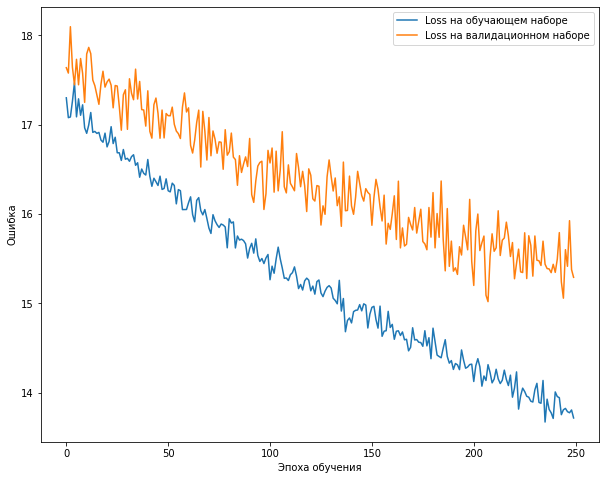

train_loss min: 13.67008113861084 , last train loss: 13.715657234191896
val_loss min: 15.018370628356934 , last val loss: 15.2908935546875


In [ ]:
# lr=0.00001  250-300 эпох
loss_train_1 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep50_60.csv')
loss_train_2 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep60_70.csv')
loss_train_3 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep70_100.csv')
loss_train_4 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep100_130.csv')
loss_train_5 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep130_160.csv')
loss_train_6 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep160_200.csv')
loss_train_7 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep200_250.csv')
loss_train_8 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'loss_lr00001_ep250_300.csv')
loss_train = pd.concat([loss_train_1,loss_train_2,loss_train_3,loss_train_4,loss_train_5,loss_train_6,loss_train_7,loss_train_8])
values_train = loss_train.values[:, 1]

loss_val_1 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep50_60.csv')
loss_val_2 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep60_70.csv')
loss_val_3 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep70_100.csv')
loss_val_4 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep100_130.csv')
loss_val_5 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep130_160.csv')
loss_val_6 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep160_200.csv')
loss_val_7 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep200_250.csv')
loss_val_8 = pd.read_csv('drive/MyDrive/Project/csv_loss_aug/'+'valloss_lr00001_ep250_300.csv')
loss_val = pd.concat([loss_val_1,loss_val_2,loss_val_3,loss_val_4,loss_val_5,loss_val_6,loss_val_7,loss_val_8])
values_val = loss_val.values[:, 1]

plt.figure(figsize=(10, 8))
plt.plot(values_train, label='Loss на обучающем наборе')
plt.plot(values_val, label='Loss на валидационном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('train_loss min:', values_train.min(), ', last train loss:', values_train[-1])
print ('val_loss min:', values_val.min(), ', last val loss:', values_val[-1])

## 4.4. Обнаружение объектов

In [ ]:
model_weight = 'drive/MyDrive/Project/weights_aug/' + 'weights_lr00001_ep250_300.h5' # Указываем файл с весами модели
max_boxes = 5 # Максимальное количество ограничивающих рамок на изображении

In [ ]:
model_YOLO = create_YOLOv3(Input(shape=(416, 416, 3)), 9//3) # Создаем модель

In [ ]:
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
print ('{} загружены.'.format(model_weight))

drive/MyDrive/Project/weights_aug/weights_lr00001_ep250_300.h5 загружены.


In [ ]:
len(data_test)

385

In [ ]:
class_true = []
for el in data_test:
  class_true.append(int(el.split(',')[-1]))
len(class_true)

385

In [ ]:
# Функция расчета сигмоиды для вектора
def sigmoid(x): # На вход подаем массив данных
  return 1/(1+np.exp(-x)) # Возвращаем сигмоиду для всех элементов массива

In [ ]:
def get_pred(x):

  model_image_size = (416,416) # Задаем размер входных данных
  image = Image.open(image_dir+x.split(' ')[0]) # Загружаем изображение 

  # Изменяем размер картинки под input_shape
  iw, ih = image.size
  w, h = (416, 416)
  scale = min(w / iw, h / ih)
  nw = int(iw * scale)
  nh = int(ih * scale)
  image_for_predict = image.resize((nw, nh), Image.BICUBIC)
  new_image = Image.new('RGB', (416,416), (128, 128, 128))
  new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
  image_for_predict = new_image 
  image_for_predict = np.array(image_for_predict) / 255.
  image_for_predict = image_for_predict.reshape(1, 416, 416, 3)


  predict = model_YOLO.predict(image_for_predict)
  num_layers = len(predict) # Получаем количество сеток
  anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
  input_shape = np.array(predict[0].shape[1:3]) * 32  # Получаем размер выходного изображения
  image_shape = np.array([image.size[1], image.size[0]]) # Сохраняем размер оригинального изображения


  best_score_by_anchors = []
  max_index_by_anchors = []
  best_box_by_anchors = []
  for i in range(9//3):
    level_anchor = i # Укажем уровень сетки
    num_anchors = len(anchors[anchor_mask[level_anchor]]) # Получаем количество анкоров
    anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим

    grid_shape = predict[level_anchor].shape[1:3] # Получим размерность сетки
    grid = [] # Массив для финальной сетки
    grid_row = [] # Массив для столбца
    for i in range(grid_shape[0]): # По всем строкам
      for j in range(grid_shape[1]): # По всем столбцам
        grid_row.append([j , i]) # Создаем элемент [j, i]
      grid.append(grid_row) # Добавляем столбец в финальную сетку
      grid_row = [] # Обнуляем данные для столбца
    grid = np.array(grid) # Переводим в numpy
    grid = np.expand_dims(grid, axis=2) # Добавляем размерность

    feats = np.reshape(predict[level_anchor], (-1, grid_shape[0], grid_shape[1], num_anchors, num_classes+5))


    # Получаем параметры бокса
    # Координаты центра bounding box
    xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
    box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] # Получаем координаты центра bounding box

    # Высота и ширна bounding box
    wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют параметрам изменения высоты и ширины анкора)
    box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box   input_shape - 416*416

    # Вероятность наличия объекта в анкоре
    conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
    box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

    # Класс объекта
    class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
    box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов



    # Корректируем ограничивающие рамки (Размер изображения на выходе 416х416)
    # И найденные параметры соответствуют именно этой размерности
    # Необходимо найти координаты bounding box для размерности исходного изображения
    box_yx = box_xy[..., ::-1].copy()
    box_hw = box_wh[..., ::-1].copy()

    new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
    offset = (input_shape-new_shape)/2./input_shape # Смотрим на сколько надо сместить в относительных координатах
    scale = input_shape/new_shape  # Находим коэфициент масштабирования
    box_yx = (box_yx - offset) * scale # Смещаем по координатам
    box_hw *= scale # Масштабируем ширину и высоту

    box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
    box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
    _boxes =  np.concatenate([
        box_mins[..., 0:1], # yMin
        box_mins[..., 1:2], # xMin
        box_maxes[..., 0:1], # yMax
        box_maxes[..., 1:2]  # xMax
    ], axis=-1)

    _boxes *= np.concatenate([image_shape, image_shape]) # Переводим из относительных координат в абсолютные


    # Получаем выходные параметры
    _boxes_reshape = np.reshape(_boxes, (-1, 4)) # Решейпим все боксы в один массив
    _box_scores = box_confidence * box_class_probs # Получаем вероятность каждого класса (умноженную на вероятность наличия объекта)
    _box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив


    

    best_score_by_anchors.append(_box_scores_reshape.max())
    max_index_by_anchors.append((_box_scores_reshape).argmax())

    best_box_by_anchors.append(_boxes_reshape[(_box_scores_reshape).argmax()//len(name_classes)])  # _boxes_reshape[(_box_scores_reshape).argmax()//len(name_classes)]


  max_index = np.argmax(best_score_by_anchors)
  class_pred = max_index_by_anchors[max_index]%len(name_classes)  # остаток от деления на 10 - номер класса с наибольшей вероятностью
  best_box = best_box_by_anchors[max_index]

  return [image, best_box, class_pred, best_score_by_anchors[max_index]]


In [ ]:
predictions = []
for el in data_test:
  predictions.append(get_pred(el))

1/1 [==============================] - 9s 9s/step


<ipython-input-52-43613740b1d0>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x)) # Возвращаем сигмоиду для всех элементов массива


1/1 [==============================] - 0s 25ms/step


In [ ]:
class_pred = []
for el in predictions:
  class_pred.append(el[2])

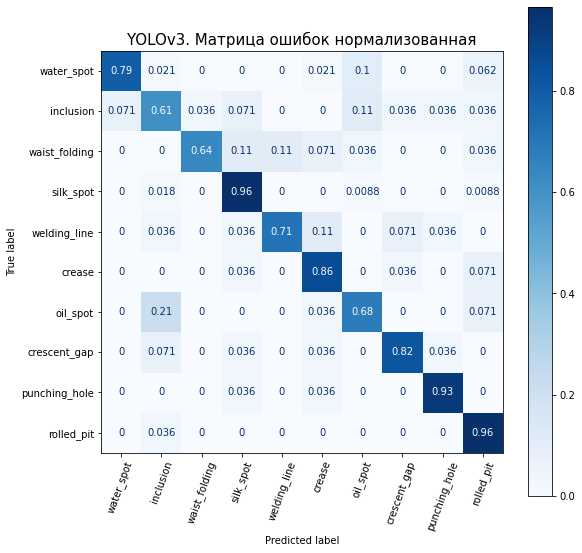

In [ ]:
# r00001_ep250_300
cm = confusion_matrix(class_true, class_pred, normalize='true')
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_title('YOLOv3. Матрица ошибок нормализованная', size=15)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CFG.class_dict.keys())   
disp.plot(ax=ax, cmap = 'Blues')
plt.xticks(rotation=70);

In [ ]:
pred_dict = defaultdict(list)
for pred in predictions:
  pred_dict[pred[2]].append(pred)
pred_dict.keys()

dict_keys([0, 9, 6, 1, 5, 3, 2, 8, 7, 4])

In [ ]:
name_classes[int(data_test[0].split(' ')[1].split(',')[4])]

'water_spot'

In [ ]:
def pred_show(pred, cl): 
  image_pred = pred[0].convert('RGB')
  thickness = (image_pred.size[0] + image_pred.size[1]) // 500
  font = ImageFont.truetype(font='/content/drive/MyDrive/Project/font.otf', size=np.floor(3e-2 * df['width'][0] + 0.5).astype('int32'))

  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[cl]
  box = pred[1]
  score = np.max(pred[3])

  
  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)
  
  bottom, left, top, right = box
  bottom = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  top = min(image_pred.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image_pred.size[0], np.floor(right + 0.5).astype('int32'))

  for i in range(thickness):
      draw.rectangle([left + i, bottom + i, right - i, top - i], outline='red')    
  del draw


  fig, axs = plt.subplots(1, 2, figsize=(15, 12))

  axs[0].imshow(image_pred)
  axs[0].set_title('PREDICTION. Predicted_class: {}, score: {:.2f}'.format(predicted_class, score), color='red') 


  for i, el in enumerate(predictions):
    if el==pred:
      img = data_test[i].split(' ')[0]
      xmin = int(data_test[i].split(' ')[1].split(',')[0])
      ymin = int(data_test[i].split(' ')[1].split(',')[1])
      xmax = int(data_test[i].split(' ')[1].split(',')[2])
      ymax = int(data_test[i].split(' ')[1].split(',')[3])
      real_class = name_classes[int(data_test[i].split(' ')[1].split(',')[4])]

      image = Image.open(image_dir+img).convert('RGB') # Загружаем изображение 
      img1 = ImageDraw.Draw(image) # Создаем экземпляр изображения

      for i in range(thickness): # Рисуем ограничивающую рамку
          img1.rectangle([xmin + i, ymin + i, xmax - i, ymax - i], outline = 'darkgreen')
      axs[1].imshow(image, cmap='gray')
      axs[1].set_title('REAL. Predicted_class: {}'.format(predicted_class), color='green');

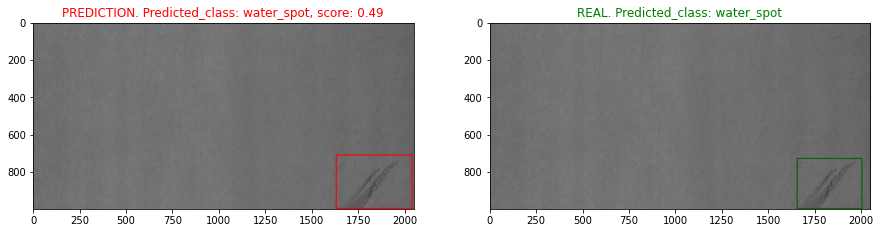

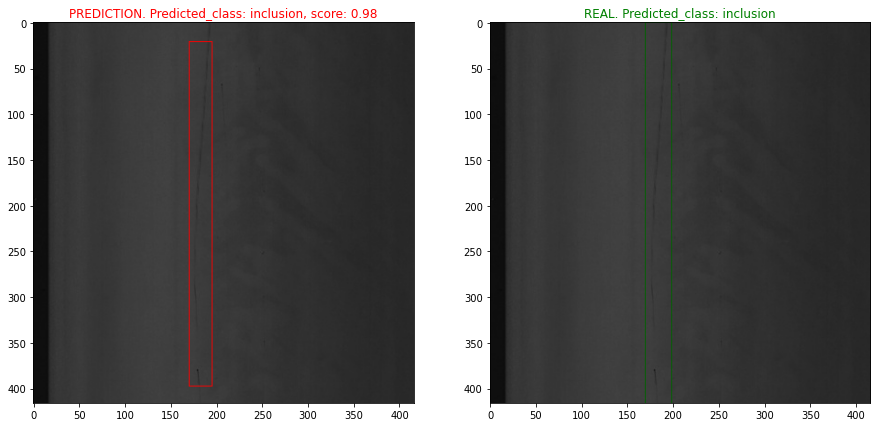

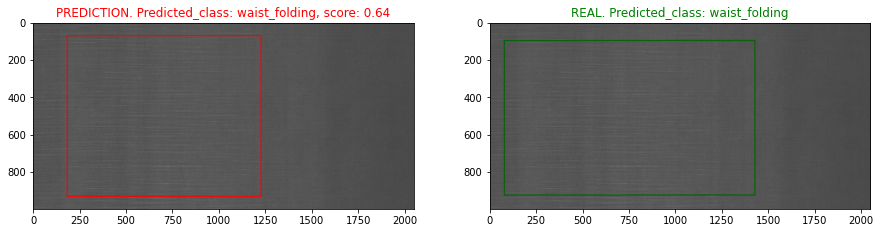

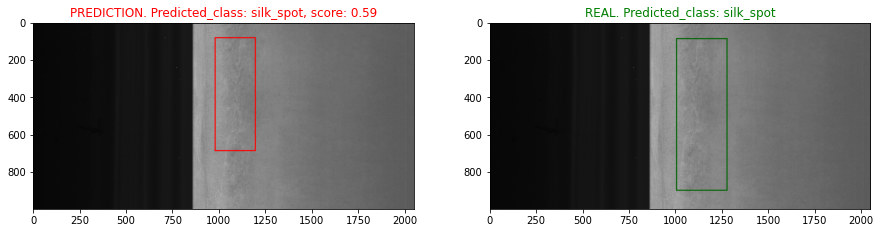

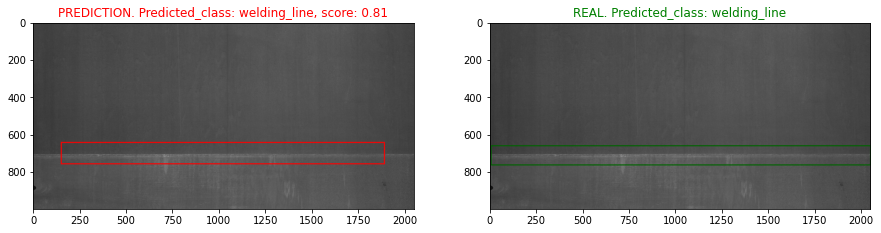

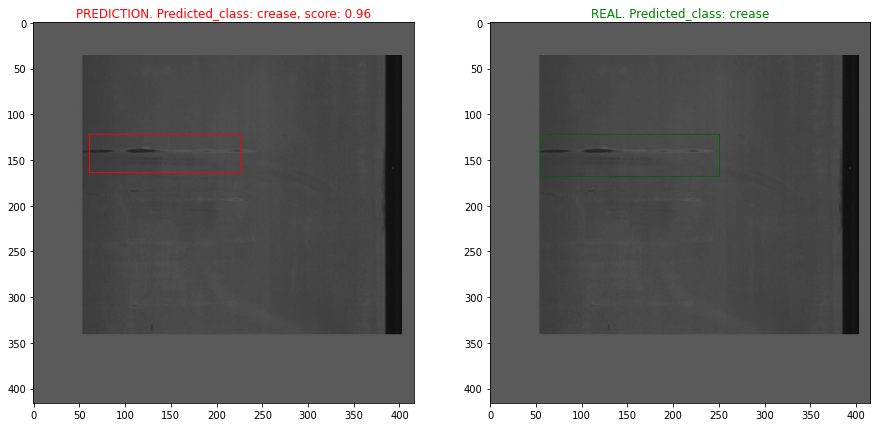

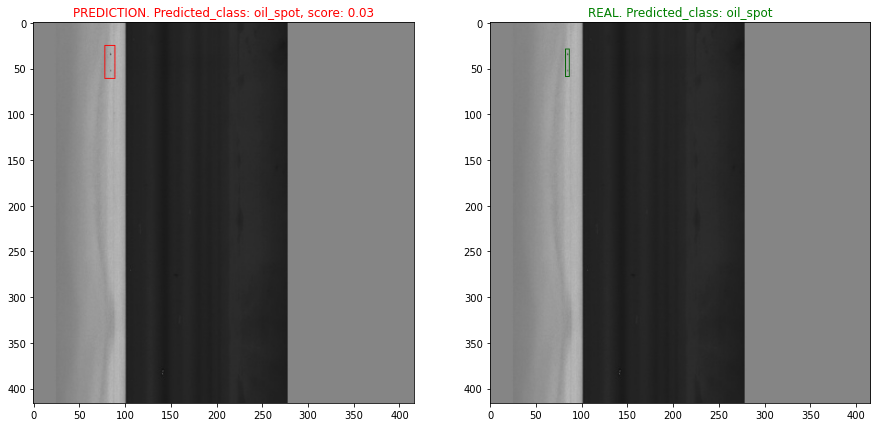

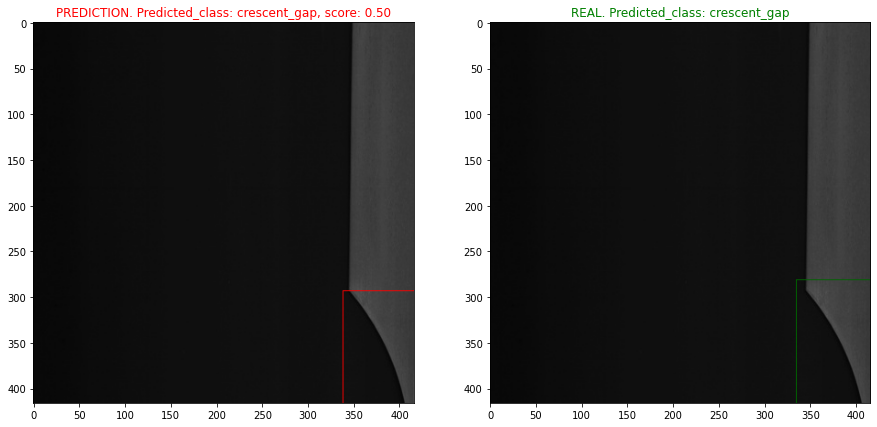

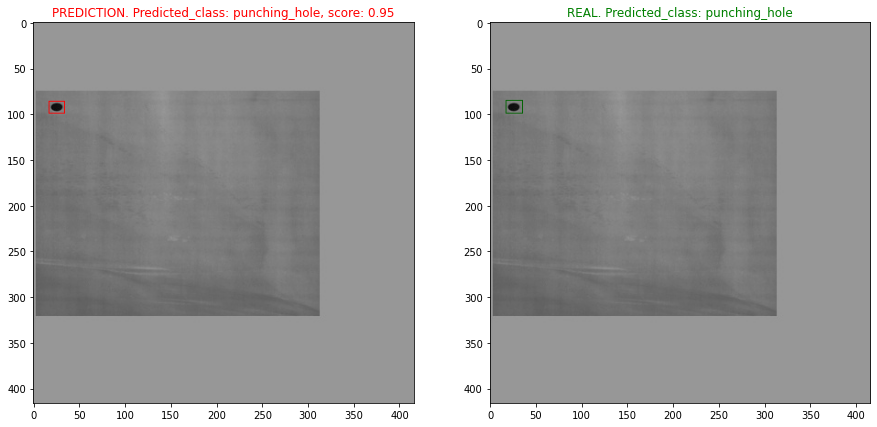

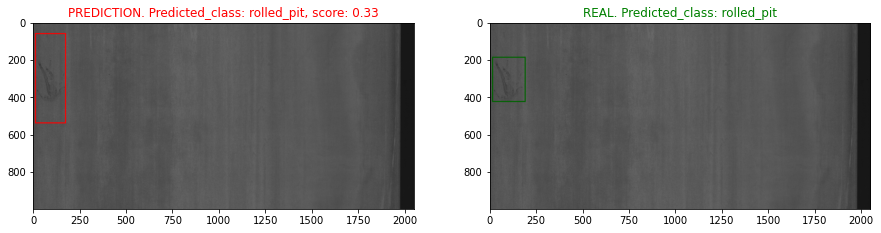

In [ ]:
for cl in range(len(name_classes)):
  pred = random.choices(pred_dict[cl])[0]
  pred_show(pred, cl)

По приведенным примерам работы сети для разных классов дефектов, видно, что YOLOv3 значительно лучше определяет местоположение дефекта, хотя качество определения класса дефекта несколько ниже, чем при использовании MobileNet (в соответствии с матрицей ошибок).

In [ ]:
xmin_real=[]
ymin_real=[]
xmax_real=[]
ymax_real=[]

for el in data_test:
  xmin_real.append(int(el.split(' ')[1].split(',')[0]))
  ymin_real.append(int(el.split(' ')[1].split(',')[1]))
  xmax_real.append(int(el.split(' ')[1].split(',')[2]))
  ymax_real.append(int(el.split(' ')[1].split(',')[3]))


ymin_pred=[]
xmin_pred=[]
ymax_pred=[]
xmax_pred=[]

for pred in predictions:
  ymin, xmin, ymax, xmax = pred[1]
  ymin_pred.append(ymin)
  xmin_pred.append(xmin)
  ymax_pred.append(ymax)
  xmax_pred.append(xmax)

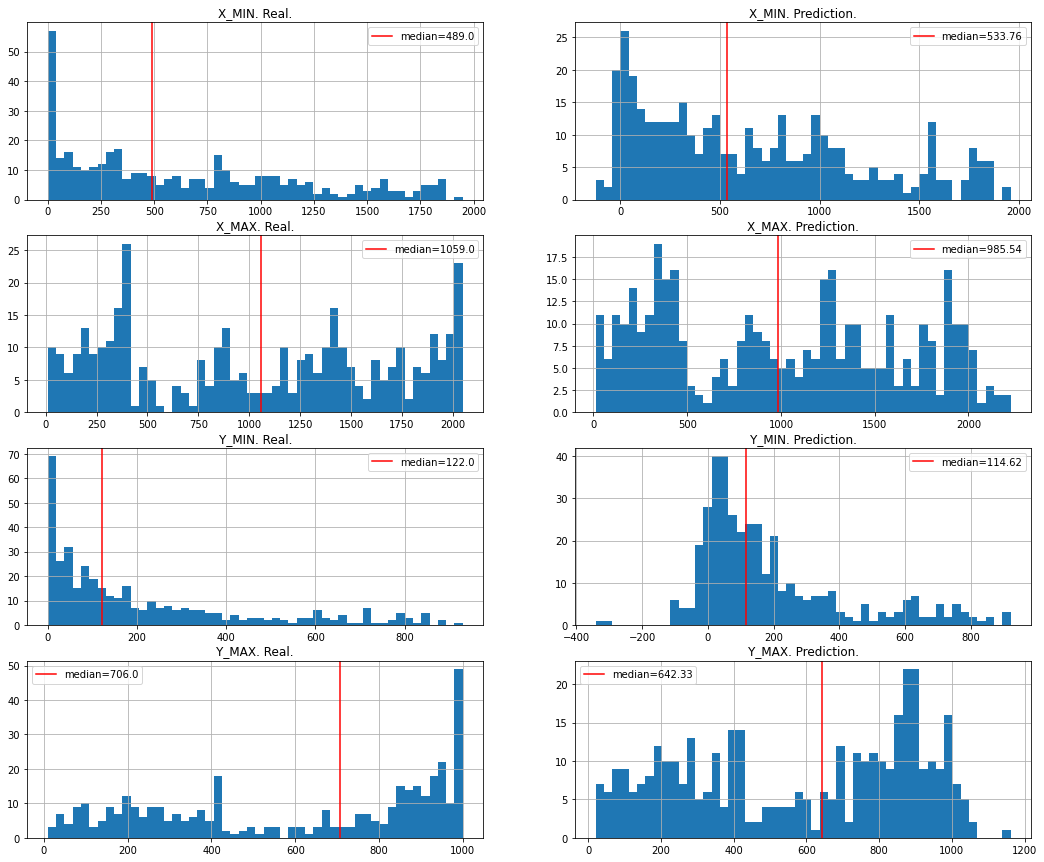

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(18, 15))

########################################## x_min ################################################
axs[0,0].set_title('X_MIN. Real.') 
axs[0,0].hist(xmin_real, bins=50)
axs[0,0].axvline(x=np.median(xmin_real), color='red', label=f"median={np.round(np.median(xmin_real),2)}")
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].set_title('X_MIN. Prediction.') 
axs[0,1].hist(xmin_pred, bins=50)
axs[0,1].axvline(x=np.median(xmin_pred), color='red', label=f"median={np.round(np.median(xmin_pred),2)}")
axs[0,1].grid()
axs[0,1].legend()

########################################## x_max ################################################
axs[1,0].set_title('X_MAX. Real.') 
axs[1,0].hist(xmax_real, bins=50)
axs[1,0].axvline(x=np.median(xmax_real), color='red', label=f"median={np.round(np.median(xmax_real),2)}")
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].set_title('X_MAX. Prediction.') 
axs[1,1].hist(xmax_pred, bins=50)
axs[1,1].axvline(x=np.median(xmax_pred), color='red', label=f"median={np.round(np.median(xmax_pred),2)}")
axs[1,1].grid()
axs[1,1].legend()

########################################## y_min ################################################
axs[2,0].set_title('Y_MIN. Real.') 
axs[2,0].hist(ymin_real, bins=50)
axs[2,0].axvline(x=np.median(ymin_real), color='red', label=f"median={np.round(np.median(ymin_real),2)}")
axs[2,0].grid()
axs[2,0].legend()

axs[2,1].set_title('Y_MIN. Prediction.') 
axs[2,1].hist(ymin_pred, bins=50)
axs[2,1].axvline(x=np.median(ymin_pred), color='red', label=f"median={np.round(np.median(ymin_pred),2)}")
axs[2,1].grid()
axs[2,1].legend()

########################################## y_max ################################################
axs[3,0].set_title('Y_MAX. Real.') 
axs[3,0].hist(ymax_real, bins=50)
axs[3,0].axvline(x=np.median(ymax_real), color='red', label=f"median={np.round(np.median(ymax_real),2)}")
axs[3,0].grid()
axs[3,0].legend()

axs[3,1].set_title('Y_MAX. Prediction.') 
axs[3,1].hist(ymax_pred, bins=50)
axs[3,1].axvline(x=np.median(ymax_pred), color='red', label=f"median={np.round(np.median(ymax_pred),2)}")
axs[3,1].grid()
axs[3,1].legend();

Приведенные распределения предсказанных значений x_min, y_min, x_max, y_max косвенно свидетельствуют о более высоком качестве предсказания границ bounding boxes в случае YOLOv3 (по сравнению с сетью на основе MobileNet), поскольку крайние (разброс пограничных значений) и медианные значения предсказаний для YOLOv3 ближе к реальным, чем в случае с сетью на основе MobileNet. 

Итоговый вывод: в качестве финальной нейросети предлагается выбрать YOLOv3, поскольку она показывает достаточно хорошее качество классификации и высокое качество предсказания месторасположения bounding boxes. Для повышения качества предсказаний необходимо продолжить обучение, т.к. по графикам обучения видно, что ошибка на тестовой и валидационной выборках продолжет снижаться с ростом количества эпох обучения.